In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

This notebook explores the shapelet transformers implemented within aeon.

Here you'll learn about the theory behind the shapelet transforms and get a first hand look at how shapelets can boost interpretability using our visualisation module.

We will:
- Highlight differences between the four transformers, in order of publishment
- Explain the Gun/No gun problem, this will give the necessary domain knowledge to help with interpreting shapelets 
- Visualise the time series from both classes
- for each transformer:
    - Time how long it takes to fit the data
    - Show what the data is transformed into
    - Explore how different classifiers rank shapelets (only for first transformer)
    - Visualise the extracted shapelets and group them by class
    - Show the best and worst shapelet for each class using Viz module
- Interpret the shapelets, try get some insight to the problem to understand classifications.
- Summarise the findings provided by each transform

If you want to learn about shapelets then go to one of our other shapelet notebooks found in [examples\classification\shapelet_based.ipynb](https://www.aeon-toolkit.org/en/stable/examples/classification/shapelet_based.html)

# A little bit about each transformer

In [2]:
import warnings

warnings.filterwarnings("ignore")
from aeon.utils.discovery import all_estimators

for k, v in all_estimators("transformer", tag_filter={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>
SAST: <class 'aeon.transformations.collection.shapelet_based._sast.SAST'>


We have four transforms, which can be grouped into two categories. Two that focus on improving accuracy and two for improving scalability (reducing computation time). ST and RDST focus on classification accuracy while RSAST and SAST focus on reducing the shapelet generation time.

## Shapelet Transform
The STC [1] introduced a groundbreaking concept by decoupling shapelet generation from the classification process. It achieved this by transforming time series data into a separate feature space that can be used with any supervised classifier - such as those available in scikit-learn. This significantly improved the accuracy compared to the initial shapelet tree algorithm [2], which was limited to using shapelets as splitting nodes. The STC iteratively initialises new shapelets, assesses their discriminative power, and removes self-similar ones, ensuring a robust selection of shapelets. Each step contains several novel contributions to the field, but for now, we will focus on the notion of transform.

However, this approach comes with relatively high time complexity due to the need to evaluate a large number of shapelet candidates during the search for the most effective shapelets. This limitation inspired a future branch of transforms — to be covered later in this mini-series.

## Scalable and Accurate Subsequence Transform

SAST [3] streamlines shapelet learning by focusing on the idea that shapelets are shared among instances of the same class, thereby avoiding redundant candidates. Unlike previous methods that relied on generating and evaluating shapelet candidates from the entire training set, SAST bypasses this step, arguing that the classifier will inherently assess feature importance during training. This means shapelet selection is more relevant for post hoc interpretability rather than boosting classifier performance. 

Drawing inspiration from 'core object recognition' — where the brain requires only a few instances to recognize objects — SAST asserts that the best shapelets for a class are present in all its instances. 

While performance improves with more reference time series, there's a risk of overfitting. SAST reduces the search space by selecting only a few reference time series per class, thus avoiding the generation of variant shapelets that essentially represent the same pattern. By transforming the data using all subsequences, the classifier learns to focus on the most discriminative features, though this approach may lead to the curse of dimensionality and could be seen as lacking interpretability 'by design'.

One limitation of this transform is its inability to handle multi-variate datasets.

## Random Dilated Shapelet Transform

RDST [4] boosts the discriminative power of shapelet-based classification by introducing two additional features for each shapelet within the transformed feature space:

- the location where the shapelet best matches the time series,
- the frequency of its occurrence.

A key innovation in RDST is dilation, which allows shapelets to stretch and become non-contiguous, effectively downsampling the data and mitigating noise. Shapelet candidates are randomly selected and then evaluated from the training data, balancing the prospects of improved accuracy with scalability and interpretability.
A possible limitation is that dilation makes the non-contiguous patterns more abstract and harder to be related back to the domain by experts.

## Random Scalable and Accurate Subsequence Transform

RSAST [5] builds on the SAST framework by employing a stratified sampling strategy for subsequence selection, further reducing the search space of shapelets, particularly for longer time series. RSAST starts by pre-computing weights using ANOVA, which guides the selection of initial points for subsequences. It then randomly selects a few time series per class and uses ACF and PACF to identify highly correlated lagged values, which serve as potential lengths for the shapelets. Shapelets are then extracted based on a predefined number of admissible starting points, transforming the original dataset into a feature space where each time series is represented by its distance to each selected subsequence. 

Along with SAST this transform is limited to univariate datasets.

# The Gunpoint classification problem

The Gun/NoGun motion capture dataset is perhaps the most studied time
series classification problem in the literature. It is also univariate making it comaptible with all four of our transforms.

The dataset consists of one female actor and one male actor making a motion with their hand, sometimes holding a gun and sometimes not. The classification problem is determining whether they were holding a gun or just miming the action. The problem is complicated by the fact the two actors differ in height (by 12 inches) and “style”, which you will notice when we visualise the time series.

The two classes are:

Gun-Draw: 

- the actors have their hands by their sides. They draw a replica gun from a hip-mounted holster, point it at a target for approximately one second, and then return it to the holster and place their hands to their sides.

Point:
- the actors have their guns by their sides. They point their index fingers to a target for approximately one second and then return their hands to their sides. 

For both classes, the researchers tracked the centroid of the actor’s performing hand in both X- and Y-axes, which appeared to be highly correlated. Because of this, the data in the archive is only the X-axis — making this a univariate time series. In the dataset, Class 1 is “gun” and Class 2 is “no gun” (pointing).

---
Before we get into it, lets make some guesses about what we may notice. How would you distinguish someone pointing a gun from someone pointing their finger at you? What are the main differences?

Firstly, a gun has noticeable weight, which could cause the arm to shake slightly when pointing. In contrast, when there’s no gun involved, the absence of a holster is significant. Without a holster, the actor has no designated place to return their hand after the movement, potentially leading to more variability in the final position. Additionally, the presence of a holster might cause a delay during the initial raising of the gun, making it a two-step motion as the gun is extracted from the holster.

---

In [3]:
import numpy as np

from aeon.datasets import load_classification

X_gun_train, y_gun_train = load_classification("GunPoint", split="train")
X_gun_test, y_gun_test = load_classification("GunPoint", split="test")

X_gun_full = np.concatenate(
    (X_gun_train, X_gun_test), axis=0
)  # Look at the entire dataset

print(f"Shape of the dataset: {X_gun_full.shape}")
print(f"Number of channels = {X_gun_train.shape[1]}")
print(f"Length of each time series = {X_gun_train.shape[2]}")
print(f"Number of training samples = {X_gun_train.shape[0]}")
print(f"Number of testing samples = {X_gun_test.shape[0]}")

Shape of the dataset: (200, 1, 150)
Number of channels = 1
Length of each time series = 150
Number of training samples = 50
Number of testing samples = 150


As you can see, we have 200 different time series, each 150 data points long. The train/test split follows the original paper, with 50 samples taken for training and the rest for testing, with each actor and class equally represented.

Note: Time series classification follows its own train/test split rather than the more general 70/30 found in wider ML. When the archive was set up, it was decided to make the train sets smaller so that the classification problems would be even more challenging to solve!

I couldn’t find the frequency of the recorded time points, but knowing that they must be at uniform intervals and that actors point for around one second; we can estimate that the whole movement lasts no longer than 8 seconds.

---


The two graphs below have the time series from the dataset plotted for each class.

*Can we find a difference between class 1 and 2 so that we can classify a given time series?* 

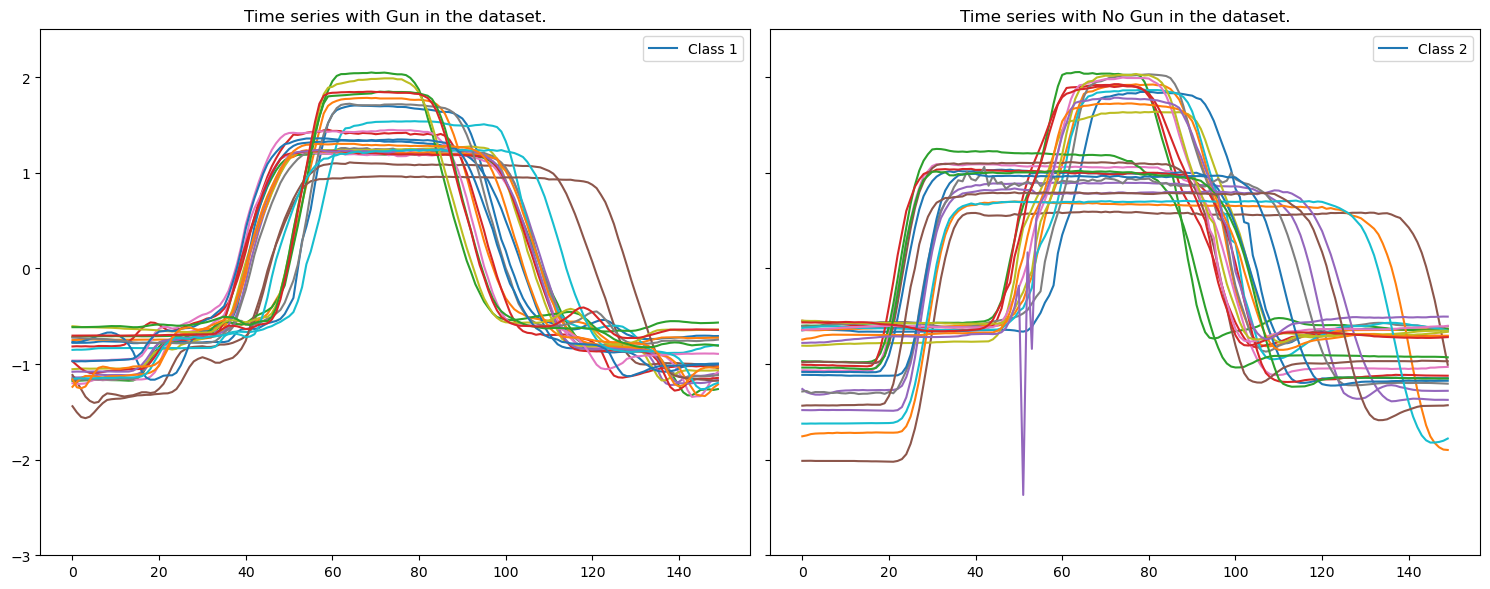

In [4]:
import matplotlib.pyplot as plt

class_1_indices = []
class_2_indices = []

# Populate the class-specific lists with training set
for i in range(0, 50):
    if y_gun_train[i] == "1":
        class_1_indices.append(i)
    elif y_gun_train[i] == "2":
        class_2_indices.append(i)


fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the Gun class
for i in class_1_indices:
    axs[0].plot(X_gun_train[i][0])
axs[0].set_title("Time series with Gun in the dataset.")
axs[0].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[0].legend(["Class 1"])

# Plot the No Gun class
for i in class_2_indices:
    axs[1].plot(X_gun_train[i][0])
axs[1].set_title("Time series with No Gun in the dataset.")
axs[1].set_ylim(-3, 2.5)  # Set the y-axis range for comparability
axs[1].legend(["Class 2"])

plt.tight_layout()
plt.show()

The two plots side by side are hard to look at and the time series as a whole look pretty similar between the two classes.

In both classes we can roughly make out the groups of time series for the female and male actor, one is taller and points for shorter than the other. Unfortunately we aren't trying to classify the actor but the presence of a gun, a much more subtle difference. 

Looking at the whole pattern seems impractical..

# Exploring each transform's shapelets

Lets take a look at a dataframe representing the testing data, each row is a time series and each column is the value at each time point. 

In [5]:
import pandas as pd

timeseries_list = []
for timeseries in X_gun_test:
    timeseries_list.append(pd.DataFrame(timeseries))
pd.concat(timeseries_list, axis=0, ignore_index=True)

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-1.125013,-1.131338,-1.138288,-1.146687,-1.138639,-1.141431,-1.143691,-1.144379,-1.154912,-1.146421,...,-1.205572,-1.281235,-1.323420,-1.345800,-1.344547,-1.301098,-1.265903,-1.212717,-1.206178,-1.218422
1,-0.626956,-0.625919,-0.627538,-0.626326,-0.624085,-0.624708,-0.625006,-0.624175,-0.624018,-0.622033,...,-0.620019,-0.621505,-0.621526,-0.624091,-0.623989,-0.624350,-0.624376,-0.619471,-0.612058,-0.606422
2,-2.001163,-1.999575,-1.999537,-1.999196,-1.999004,-2.000315,-1.998425,-2.000679,-1.999995,-2.000786,...,0.312798,0.242217,0.145716,0.014012,-0.151780,-0.333427,-0.577435,-0.812720,-1.071147,-1.323383
3,-1.004587,-0.999843,-0.995250,-0.992019,-0.991200,-0.987556,-0.996473,-0.996878,-0.998673,-0.997882,...,-1.080245,-1.060166,-1.044471,-1.039528,-1.040693,-1.044162,-1.044058,-1.044916,-1.044226,-1.043262
4,-0.742625,-0.743770,-0.743900,-0.744873,-0.744745,-0.745364,-0.747078,-0.746615,-0.746705,-0.745859,...,-0.699312,-0.696897,-0.694059,-0.689150,-0.687534,-0.682798,-0.682153,-0.681030,-0.670519,-0.657403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.580006,-0.583332,-0.586108,-0.589118,-0.591951,-0.599196,-0.609292,-0.618504,-0.627164,-0.635995,...,-0.536779,-0.537708,-0.537554,-0.538319,-0.538915,-0.541542,-0.545838,-0.546621,-0.548831,-0.553552
146,-0.728153,-0.730242,-0.733560,-0.734188,-0.734331,-0.734660,-0.733856,-0.733397,-0.732929,-0.731822,...,-0.788042,-0.768710,-0.748156,-0.728561,-0.711126,-0.699604,-0.689584,-0.687476,-0.686448,-0.690183
147,-0.738012,-0.736301,-0.731226,-0.728455,-0.728883,-0.727372,-0.724525,-0.720916,-0.719828,-0.719228,...,-0.617504,-0.613856,-0.611590,-0.609785,-0.609814,-0.608848,-0.610023,-0.609646,-0.608616,-0.612177
148,-1.265111,-1.256093,-1.259421,-1.256351,-1.253265,-1.260103,-1.265063,-1.256396,-1.246350,-1.249132,...,-1.192413,-1.193333,-1.195697,-1.189598,-1.177099,-1.188014,-1.189629,-1.199970,-1.193374,-1.192835


Currently the data is a time series, for which there is a limited number of classifiers. What the shapelet transforms achieve is mapping this data into a form that can be fed to any supervised classifier. They each achieve this slightly differently with their own takes on the transformed output.

In scientific tables, the convention is to have the independent variable in the columns and the dependent variables in the rows. In a time series dataset, time is considered the independent variable because it provides the reference point across which measurements are taken. Each column represents a specific time point. The different time series (or the variables within a time series) —represent the observed values at each time point—are the dependent variables, which are naturally placed in the rows.

#### Random Shapelet Transform

In our exploration of RST we will use the same parameters as the published paper []. 

The aeon implementation matches the experimental parameters explored in the Gunpoint problem, the only parameter which is required to be set is max_shapelets to be 10. MAXLEN is set to the length of
the shortest time series in the training set. For MINLEN, they hardcoded the shortest possible length to three which is the minimum meaningful length. 


You can use the transform directly in aeon, but we will mostly explore it via the transform classifier because it lets play around with the ranking of shapelets.

In [6]:
import time

import pandas as pd

from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

start_time = time.time()
rst = RandomShapeletTransform(max_shapelets=10, random_state=99).fit(
    X_gun_train, y_gun_train
)
end_time = time.time()

# Show the elapsed transform time
rst_elapsed_time = end_time - start_time
print(f"Time taken to fit: {rst_elapsed_time:.4f} seconds")

pd.DataFrame(rst.transform(X_gun_test))

Time taken to fit: 13.9589 seconds


,0,1,2,3,4,5,6,7,8,9
0,0.003717,0.020089,0.043620,1.320980,0.001551,0.008399,0.838023,1.004437,0.900919,0.089512
1,0.133435,0.150480,0.117333,0.033369,0.122150,0.114631,0.040733,0.239368,0.057699,0.009116
2,0.152721,0.193469,0.132979,1.079411,0.187685,0.217339,0.827136,0.935028,0.884864,0.246486
3,0.045800,0.028813,0.019837,1.356602,0.037309,0.026347,0.861129,1.034721,0.935163,0.078142
4,0.045097,0.038882,0.066422,1.358289,0.047304,0.031171,0.865805,1.015214,0.299602,0.051525
...,...,...,...,...,...,...,...,...,...,...
145,0.163862,0.204825,0.143582,0.366795,0.158322,0.149433,0.271026,0.872067,0.214193,0.009775
146,0.051390,0.038367,0.062432,1.337244,0.064614,0.039837,0.847953,1.000116,0.926387,0.049306
147,0.179117,0.217945,0.148447,0.062721,0.171713,0.158122,0.047981,0.259901,0.072351,0.008373
148,0.154436,0.176792,0.129151,0.954934,0.158068,0.166027,0.774495,0.911700,0.841725,0.262808


The data frame shows what the transformed data looks like compared to the original. As you can see, we still have the 150 time series - the rows. But now, instead of the columns representing the value at each time point, the columns contain the shortest distance between each of the 10 best shapelets and the time series. This space is no longer a time series and can be treated as a typical classification problem.

If you’re wondering how we decided on the 10 best shapelets, great! That’s a worthy question. During the shapelet generation process, we evaluate the discriminative power of each candidate using a quality measure, in this case, information gain. With all candidates measured, we chose the 10 most discriminative candidates, 5 for each class. For a deeper understanding I recommend reading the publish paper.

The data frame isn’t very informative about the shapelets themselves… Let’s plot the 10 best shapelets found — the above columns.

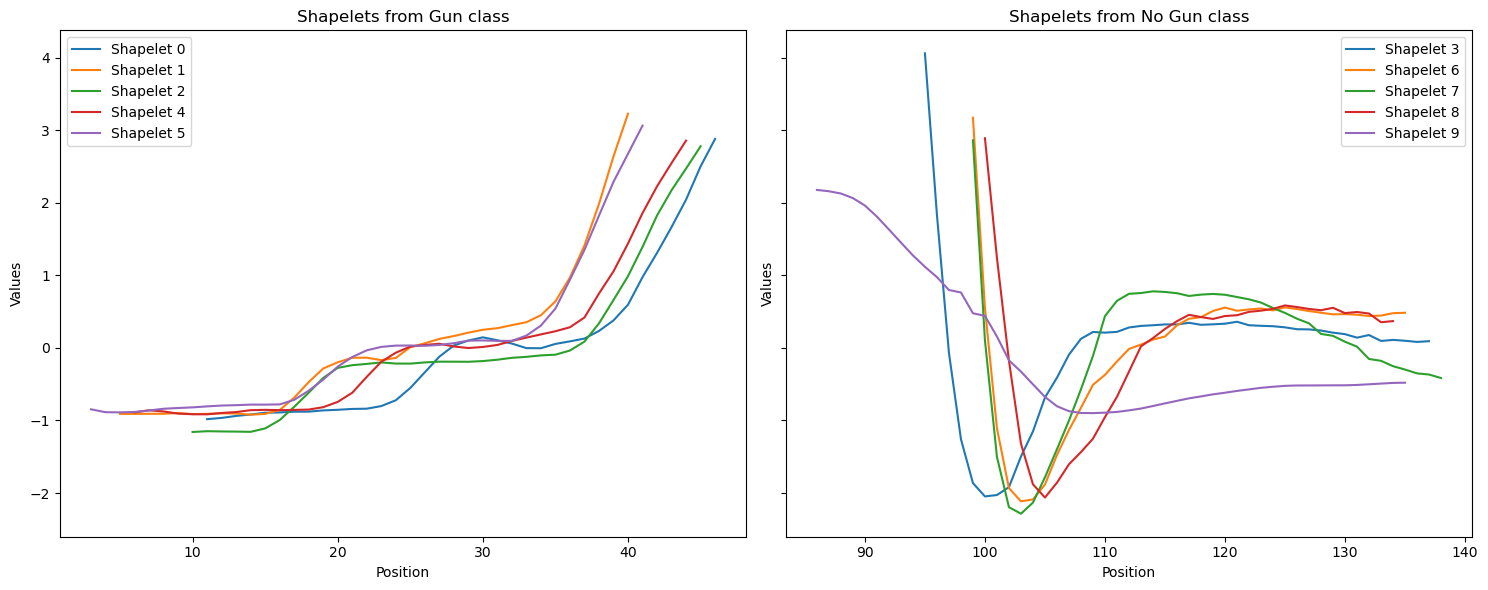

In [7]:
import matplotlib.pyplot as plt

gun_class = "1"
nogun_class = "2"

shapelets = rst.shapelets

shapelet_gun_vals = []
shapelet_gun_pos = []
shapelet_gun_indices = []

shapelet_nogun_vals = []
shapelet_nogun_pos = []
shapelet_nogun_indices = []

for idx, shapelet in enumerate(shapelets):
    if shapelet[5] == gun_class:
        shapelet_gun_vals.append(shapelet[6])
        shapelet_gun_pos.append(shapelet[2])
        shapelet_gun_indices.append(idx)  # Store the original index

for idx, shapelet in enumerate(shapelets):
    if shapelet[5] == nogun_class:
        shapelet_nogun_vals.append(shapelet[6])
        shapelet_nogun_pos.append(shapelet[2])
        shapelet_nogun_indices.append(idx)  # Store the original index

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first set of shapelets (Gun class)
for i in range(len(shapelet_gun_vals)):
    x_values = [x + shapelet_gun_pos[i] for x in range(len(shapelet_gun_vals[i]))]
    axs[0].plot(
        x_values, shapelet_gun_vals[i], label=f"Shapelet {shapelet_gun_indices[i]}"
    )

axs[0].set_title("Shapelets from Gun class")
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Values")
axs[0].legend()

# Plot the second set of shapelets (No Gun class)
for i in range(len(shapelet_nogun_vals)):
    x_values = [x + shapelet_nogun_pos[i] for x in range(len(shapelet_nogun_vals[i]))]
    axs[1].plot(
        x_values, shapelet_nogun_vals[i], label=f"Shapelet {shapelet_nogun_indices[i]}"
    )

axs[1].set_title("Shapelets from No Gun class")
axs[1].set_xlabel("Position")
axs[1].set_ylabel("Values")
axs[1].legend()


plt.tight_layout()
plt.show()

Isn’t this much nicer than the complicated time series graph?

We can more easily look for the essential differences between the two classes now. By generating the best 10 shapelets, we have already learned that there is something of interest during the lifting movement and the descending one; the two distinct groups of shapelets correspond to each class. This means there is a small pattern specific to raising the gun and one for lowering the empty hand. What could they be?

A property of ST worth noting is that each class must have the same number of shapelets. This might leave out informative shapelets from one class to enforce this balance. But on the bright side, it lets us pay equal attention to the possible discriminating patterns of each class.

In [8]:
from collections import Counter

shapelets = rst.shapelets
classes = []
for shapelet in shapelets:
    classes.append(shapelet[5])
Counter(classes)

Counter({'1': 5, '2': 5})

A property of the Shapelet Transform worth noting is that each class must have the same number of shapelets. This might leave out informative shapelets from one class to enforce for this balance. But on the bright side, it lets us pay equal attention to the possible discriminating patterns of each class.

---
Now, let’s look at how classifiers rank these shapelets relative to one another. Tree-based and linear classifiers are inherently interpretable, as you can study the weights in the model to understand which feature is more or less important. So let’s explore an example of each — a Logistic Regression and a Random Forest.

I emphasise that the purpose is not to evaluate classification performance but to use the feature importance provided by the classifiers to aid in comparing shapelets later down the line. We will explore these two because the rankings are simple to understand; in practice, the Ridge Classifier may lead to better performance than the Logistic Regressor, but the regularisation can make understanding the shapelet rankings less intuitive.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import ShapeletTransformClassifier

rst_rf = ShapeletTransformClassifier(
    estimator=RandomForestClassifier(ccp_alpha=0.01),
    max_shapelets=10,
    random_state=99,  # Same random state as for the individual transform from above
).fit(X_gun_train, y_gun_train)


rst_lr = ShapeletTransformClassifier(
    estimator=LogisticRegression(),
    max_shapelets=10,
    random_state=99,  # Same random state as for the individual transform from above
).fit(X_gun_train, y_gun_train)

With both STC variants fit, lets make sure that they have the same 10 shapelets as above.

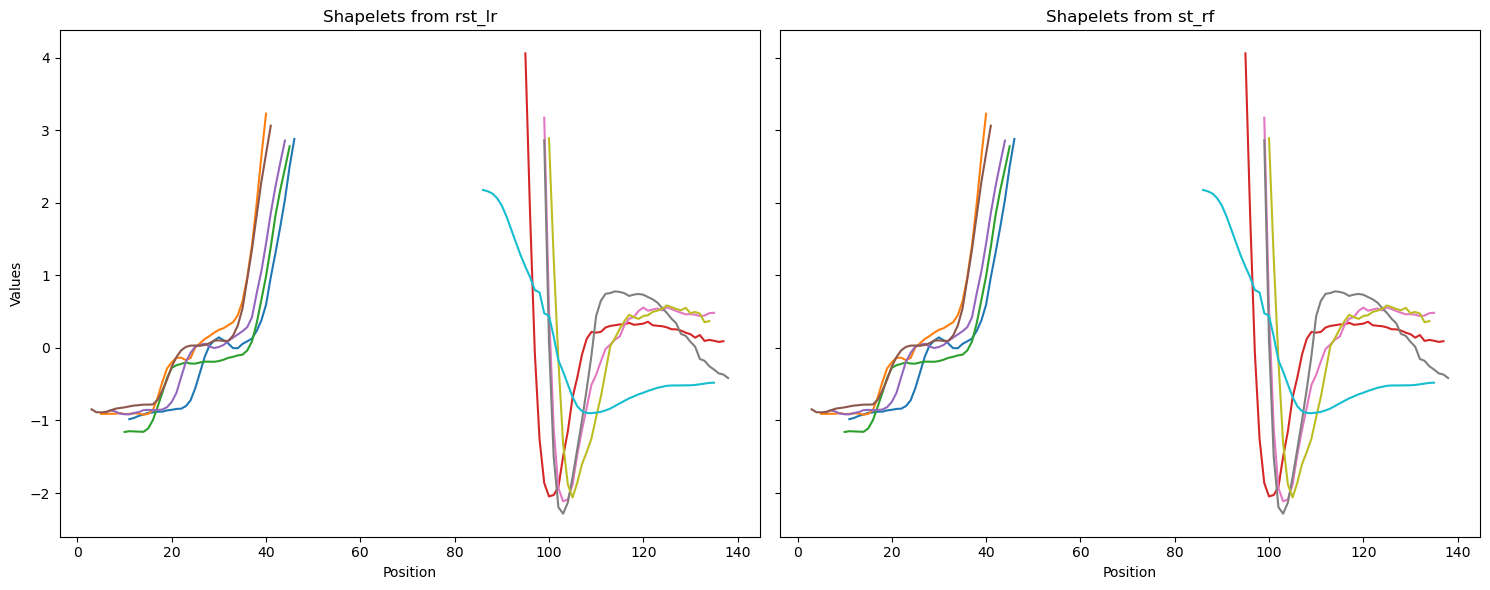

In [10]:
import matplotlib.pyplot as plt

# First set of shapelets (from rst_lr)
shapelets_lr = rst_lr._transformer.shapelets
shapelet_vals_lr = []
shapelet_pos_lr = []

for shapelet in shapelets_lr:
    shapelet_vals_lr.append(shapelet[6])
    shapelet_pos_lr.append(shapelet[2])

# Second set of shapelets (from st_rf)
shapelets_rf = rst_rf._transformer.shapelets
shapelet_vals_rf = []
shapelet_pos_rf = []

for shapelet in shapelets_rf:
    shapelet_vals_rf.append(shapelet[6])
    shapelet_pos_rf.append(shapelet[2])

# Create a figure with 2 subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot the first set of shapelets (rst_lr)
for i in range(len(shapelet_vals_lr)):
    x_values = [x + shapelet_pos_lr[i] for x in range(len(shapelet_vals_lr[i]))]
    axs[0].plot(x_values, shapelet_vals_lr[i])

axs[0].set_title("Shapelets from rst_lr")
axs[0].set_xlabel("Position")
axs[0].set_ylabel("Values")

# Plot the second set of shapelets (st_rf)
for i in range(len(shapelet_vals_rf)):
    x_values = [x + shapelet_pos_rf[i] for x in range(len(shapelet_vals_rf[i]))]
    axs[1].plot(x_values, shapelet_vals_rf[i])

axs[1].set_title("Shapelets from st_rf")
axs[1].set_xlabel("Position")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Great, now we can safely compare their rankings. We will use our shapelet visualisation module made specifically for aiding the interpretability of the transforms.

In [11]:
import pandas as pd

from aeon.visualisation import ShapeletClassifierVisualizer

rst_lr_vis = ShapeletClassifierVisualizer(rst_lr)
rst_rf_vis = ShapeletClassifierVisualizer(rst_rf)

rst_rf_vis_index_0 = rst_rf_vis._get_shp_importance(0)[0]  # gun
rst_rf_vis_index_1 = rst_rf_vis._get_shp_importance(1)[0]  # no gun
rst_lr_vis_index_0 = rst_lr_vis._get_shp_importance(0)[0]  # gun
rst_lr_vis_index_1 = rst_lr_vis._get_shp_importance(1)[0]  # no gun

# Store the elements at each position in the lists
elements_in_position = {
    "Rank": list(range(10)),
    "Random forest Gun": rst_rf_vis_index_0,
    "Random forest No Gun": rst_rf_vis_index_1,
    "Logistic Regression Gun": rst_lr_vis_index_0,
    "Logistic Regression No Gun": rst_lr_vis_index_1,
}

# Convert the dictionary to a DataFrame
pd.DataFrame(elements_in_position).set_index("Rank")

,Random forest Gun,Random forest No Gun,Logistic Regression Gun,Logistic Regression No Gun
Rank,,,,
0,0,0,5,3
1,4,4,4,8
2,2,2,1,6
3,3,3,9,7
4,7,7,0,2
5,6,6,2,0
6,1,1,7,9
7,5,5,6,1
8,8,8,8,4


As you can see, the different classifiers find the same shapelets to be of different importance.

Two patterns emerge in the importance ranking; the Random Forest finds the same shapelets equally important for both classes, while the Logistic Regressor flips the importance for each class.

This makes sense, given that RFs are tree-based and use information gain as the quality measure; the most discriminative shapelet is the best at distinguishing the two classes, so it’s just as important for both. While the importance of the Logistic Regressor is found using the coefficients assigned to the features (in this case, shapelets), a linear model assigns positive or negative coefficients to features based on how strongly they correlate with each class. This means a shapelet contributing positively to one class will contribute negatively to another, resulting in a flip in importance across classes. In the case of a multiclass problem, there wouldn’t be this flip in importance, instead a one-vs-all approach is implemented for shapelet importance.

In our case, because distance is the metric, our visualisation module flips the coefficients to determine class importance. A positive weight means that as a value increases, the chance of being class 1 increases, but distance is inversely correlated to a class — the closer a shapelet fits a time series, the more likely it is class 1.

This is a good time to remind you of an argument made by SAST. Ranking shapelets independently to the classifier may harm performance. We have just first hand seen how different classifier families rate the shapelets. What if the Logistic Regression Classifier really liked a shapelet ranked 15th according to information gain?

---
Lets take a look at each classifier's most important shapelet. 

But first we should understand how they are represented in our visalisation module.

- Boxplot of Min (Top Left): The distribution of the minimum distances between the shapelet and each class. As expected, the shapelet fits class 0 more consistently than the other.

- Shapelet Params (Bottom Left): This graph displays the shapelet’s pattern and length and states that normalisation was used.

- Distance Vectors of Examples (Bottom Right): This graph compares how well the shapelet fits the two time series from the ‘Best Match on Examples’ graph, at each point.

- Best Match on Examples (Top Right): This graph shows how the shapelet fits a time series from each class. The shapelet should, and does, align more closely with the time series of class 0.

Due to label encoding Class 0 related to '1' which is Gun & Class 1 related to '2' which is No Gun.

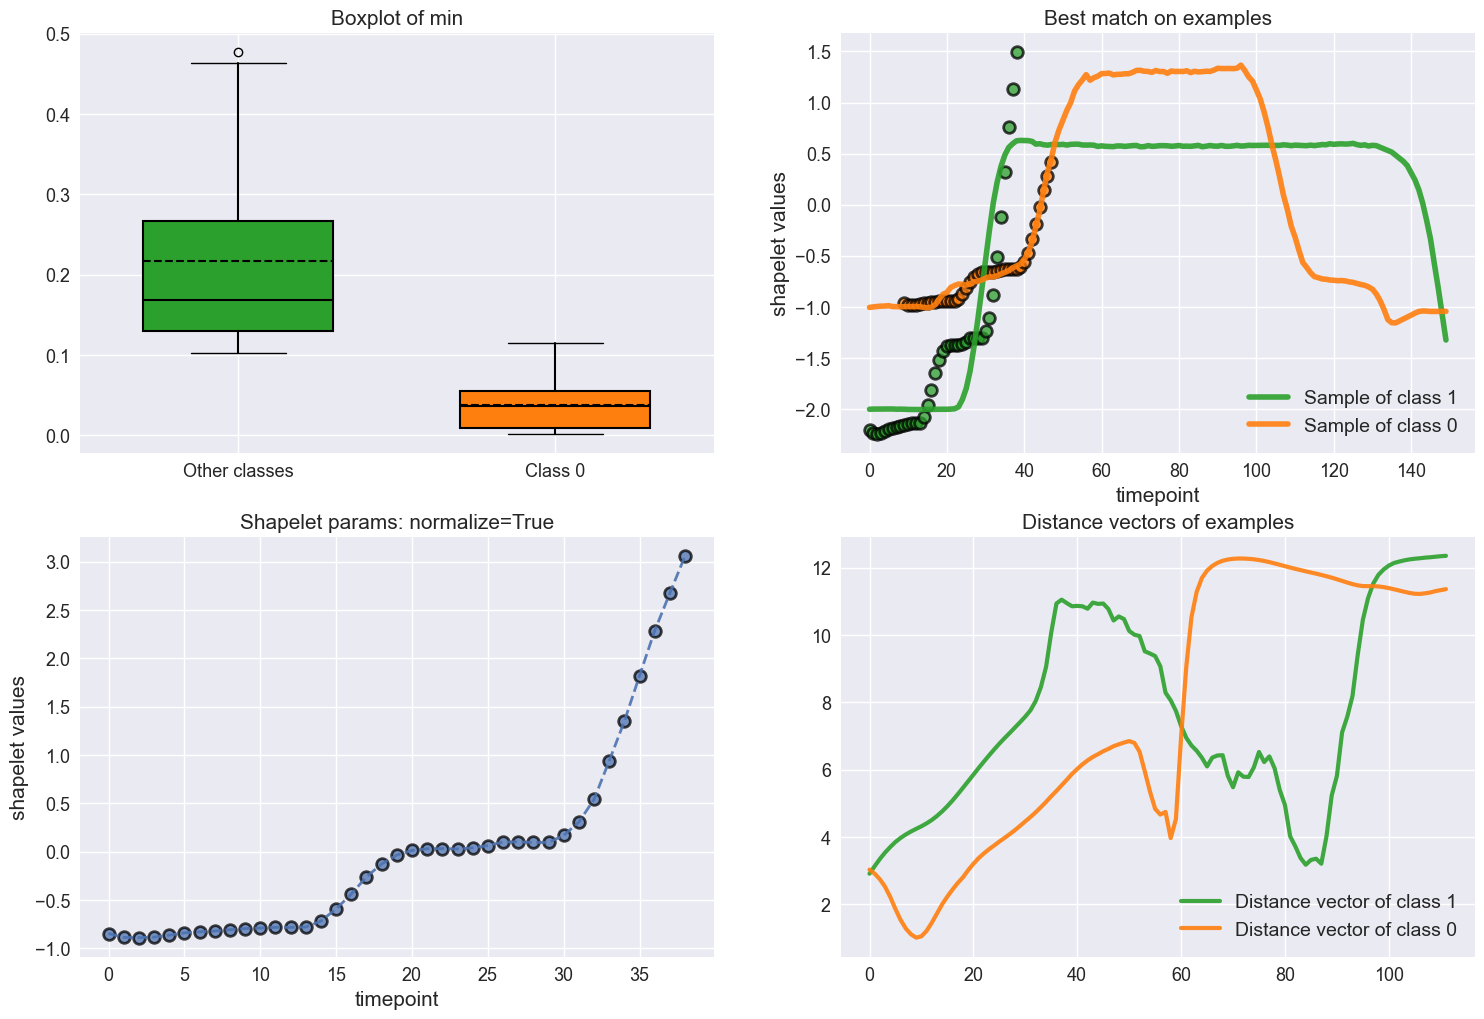

In [12]:
fig = rst_lr_vis.visualize_shapelets_one_class(  # this is worst for other class
    X_gun_test,
    y_gun_test,
    0,  # Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

If you’re wondering why the same shapelet looks different when fit to the orange and green time series, that is due to the normalisation parameter; this will become even more apparent in later graphs.

This parameter normalises the distance between the shapelet and the subseries enabling scale invariance.
This means, no matter the amplitude of the pattern, it will be noticed if it’s present. Think of the two actors who have different heights, if they both shrug their shoulders when holding the gun the change in height will be different but normalisation abstracts the pattern to be found in them both.

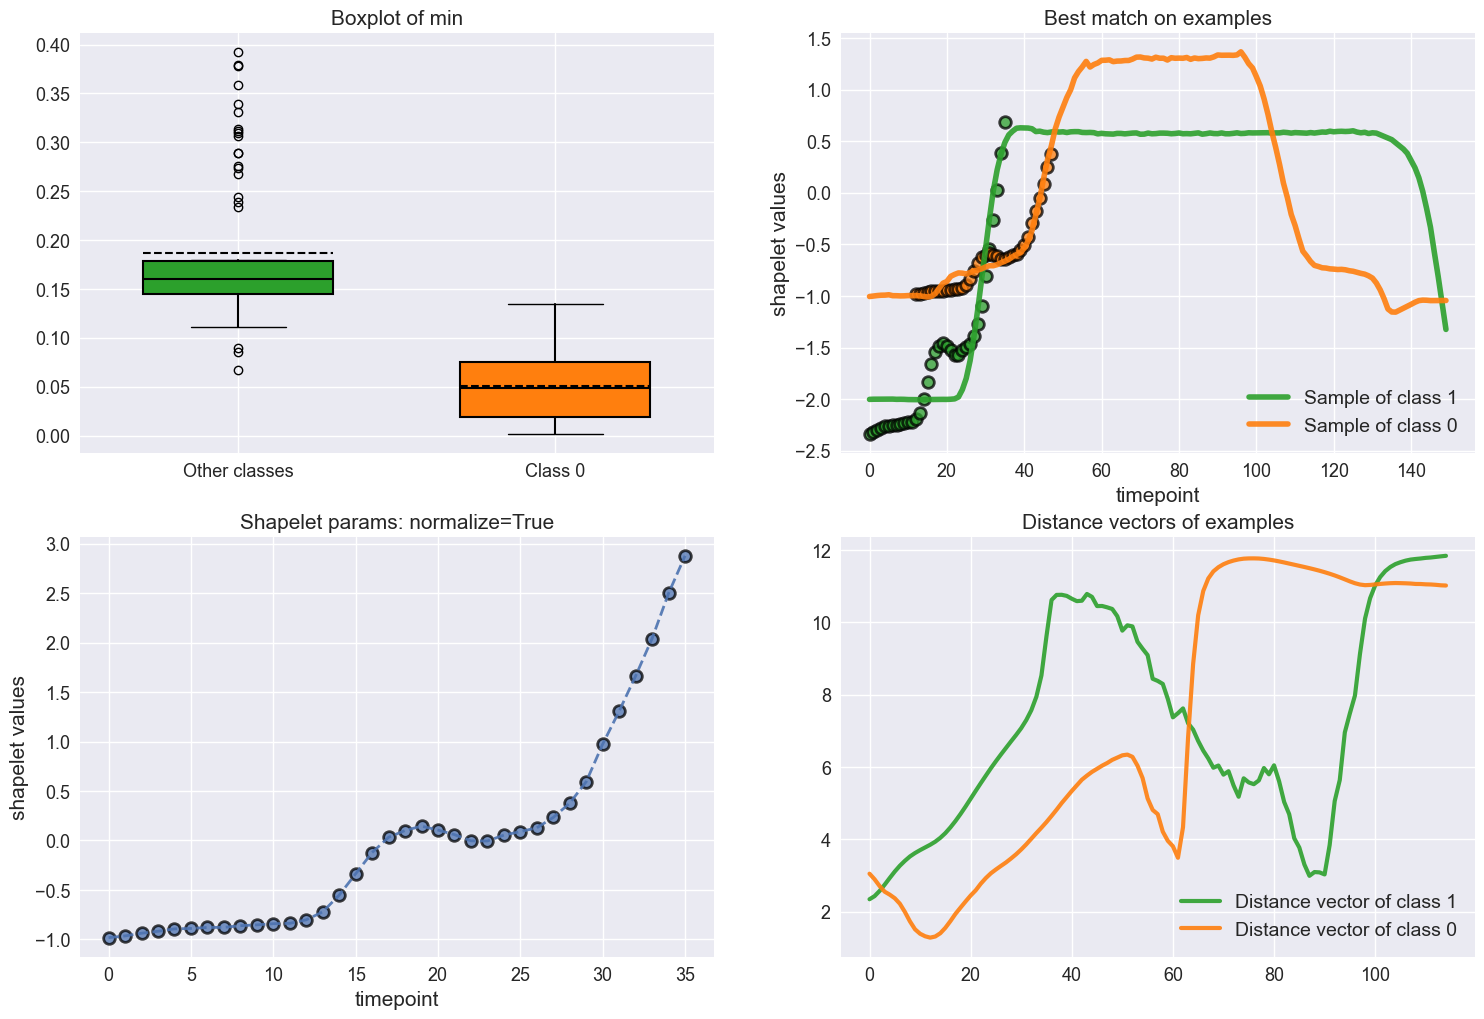

In [13]:
fig = rst_rf_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun but RF rankes irrespective to class
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

Here, we learn that for the Logistic Regressor, the most important shapelet for discriminating the Gun class is found during the raise action rather than descent. This seems intuitive enough; the best shapelet for a class should come from that class. The shapelet’s fit to the time series from the Gun class is consistent. At the same time, there is relatively more variation in its fit for the other, which is why it’s not very discriminative for the No Gun class. Again, a shapelet from one class, by definition, should not fit the other better.

Interestingly, for the Random Forest, the best shapelet is related to the raise, which comes from the Gun Class. This is interesting because the first paper using shapelets found a shapelet from the No Gun class to be the most discriminative. This goes to show the impact classifiers have on ranked shapelets.

Remember, the importance of the Random Forest’s feature is independent of class. The boxplot reemphasises that the shapelet is ranked first for both classes by the slight distance variance. There is a clear separation between the two, which relates to reducing entropy.

By seeing the shapelet’s best fit on the opposing class, we identify the pattern in its class and not in the other. By the definition of shapelets, we know that the pattern of a class’ shapelet won’t be found in the other class’ time series — we don’t need to plot this shapelet against all instances of the other class to validate the claim.

In both shapelets, a unique two-step raise is highlighted when superposed on top of a time series from the No Gun class, which rises in one go. This could be explained by the idea that the gun in the holster takes some time to get out, whereas the basic point action requires the actor to raise their hand.


---
Having looked at the best shapelets, maybe we can get additional insight from the worst ones too.

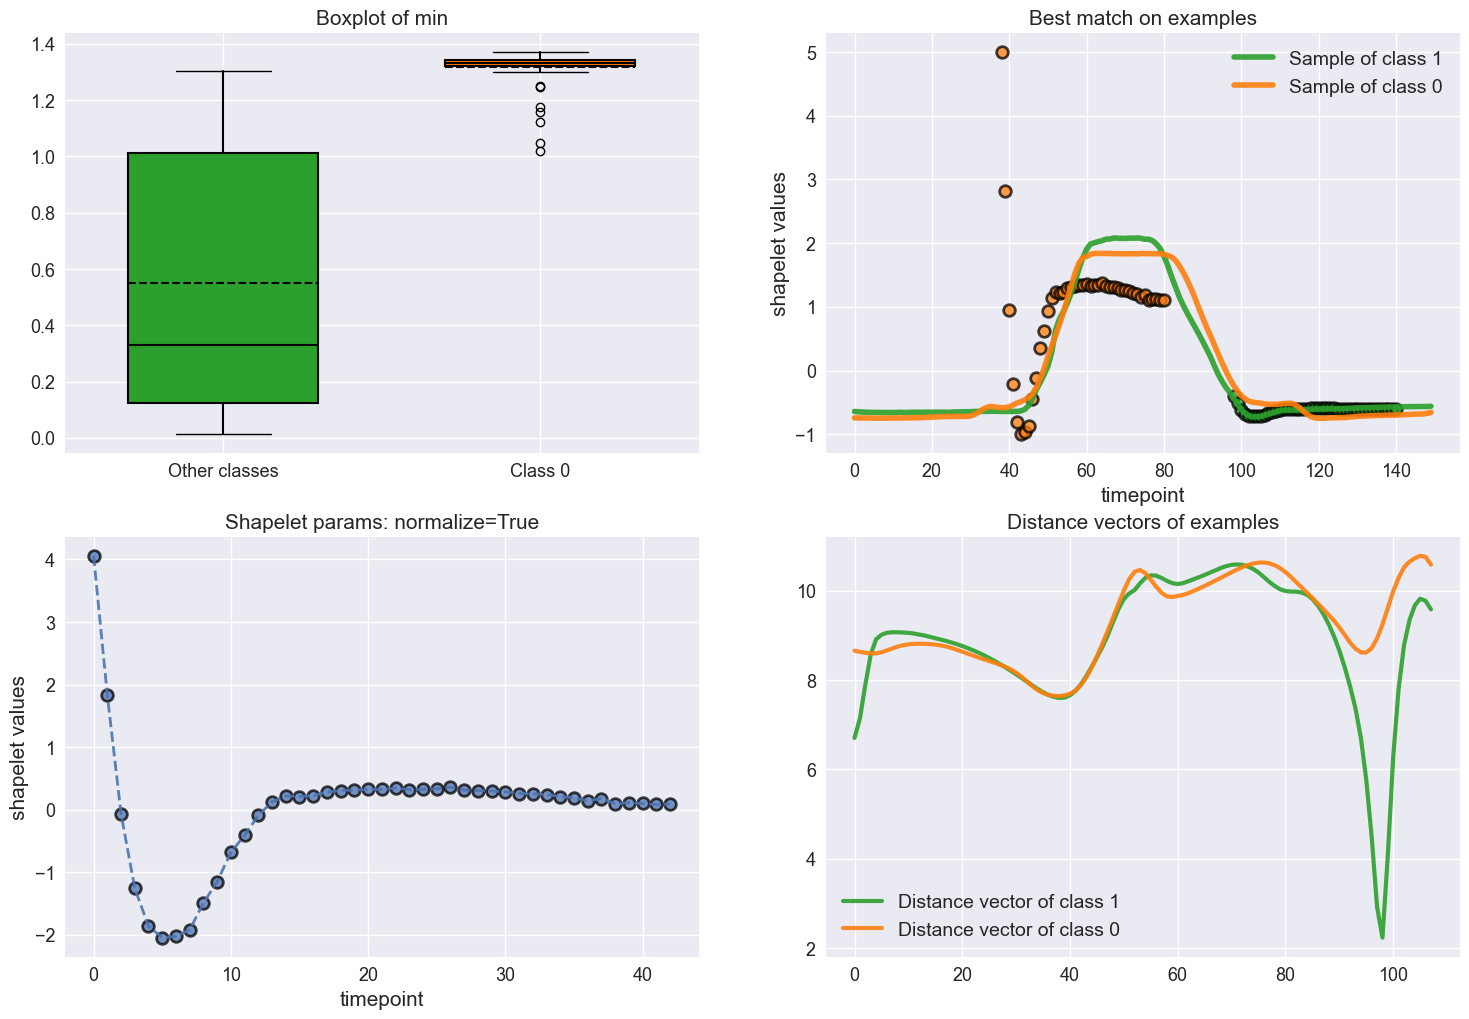

In [14]:
fig = rst_lr_vis.visualize_shapelets_one_class(  # this is best for other class
    X_gun_test,
    y_gun_test,
    0,  # Gun
    best=False,  # Showing worst shapelet for Gun which should be best for No Gun
    id_example_class=2,
    id_example_other=2,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

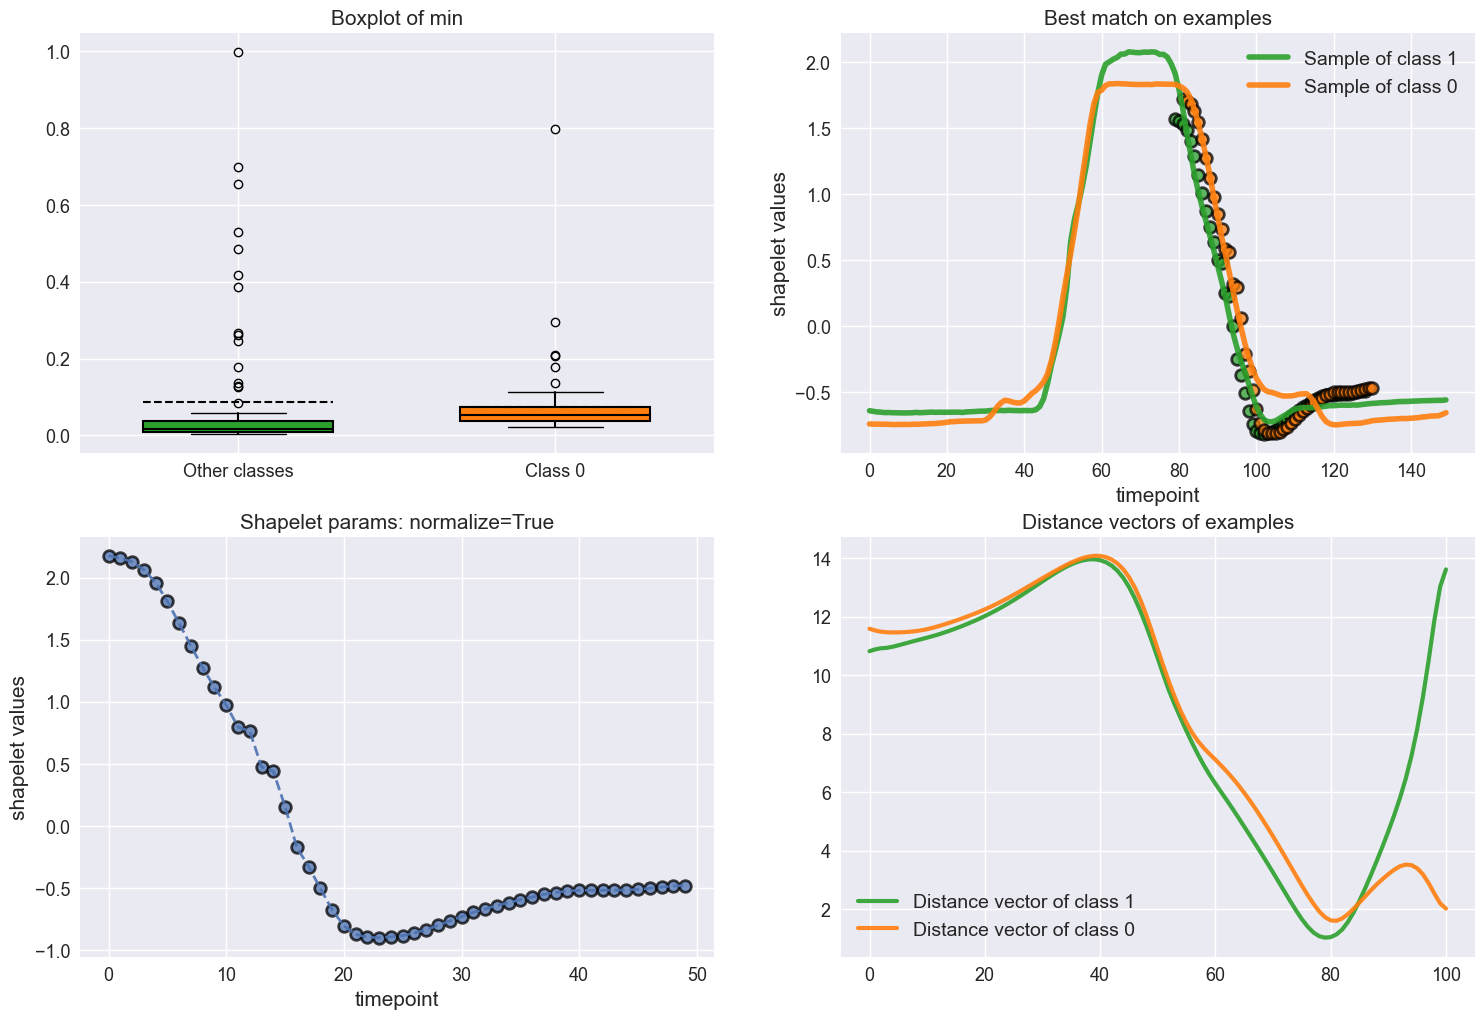

In [15]:
fig = rst_rf_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun but RF rankes irrespective to class
    best=False,
    id_example_class=2,
    id_example_other=2,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

It seems intuitive to think that the worst shapelet will be further from its class time series than the best. But this is an erroneous generalisation; what makes a shapelet valuable to an RF classifier is not how well it fits its own class but how differently it fits the other. The perfect shapelet will fit its class while completely incompatible with the other. That’s why if you compare the distance plots of the best and worst shapelets, they’re not that different; also, take into account these are the 10 best out of the 10,000 candidates. We should really be saying ‘least best’.

Observing the best No Gun shapelet superposed on top of a Gun time series shows us that the described pattern isn’t present anywhere. The best match is still far off (and in the wrong place). I know shapelets are phase invariant, but for this problem, the location of a pattern matters. Instead of observing the Best match plot, we can speculate how the descent differs between the Gun and No Gun classes by comparing the best shapelet for the No Gun class according to the Logistic Regressor and the worst overall shapelet according to the Random Forest, which also comes from the No Gun class — we see that the better discriminating shapelet has a deeper dip.

In fact, looking at the Best match plot for the Random Forest shapelet, we see that the No Gun time series has a dip, unlike the Gun series. Let’s call this ‘overshoot’; maybe because the actor isn’t holding a prop, they swing their arm past the holster.

The reason the worst shapelet is the worst for the Random forest is shown in the box plots of the distance distribution for both very similar classes. This means there is a less clear threshold for splitting the two classes.

#### Random Dilated Shapelet Transform

In [16]:
import time

from aeon.transformations.collection.shapelet_based import (
    RandomDilatedShapeletTransform,
)

shapelet_lengths = array = [9, 11, 13]

start_time = time.time()
rdst = RandomDilatedShapeletTransform(
    max_shapelets=10, shapelet_lengths=shapelet_lengths, random_state=99
).fit(X_gun_train, y_gun_train)
end_time = time.time()

# Show the elapsed transform time
rdst_elapsed_time = end_time - start_time
print(f"Time taken to fit: {rdst_elapsed_time:.4f} seconds")

pd.DataFrame(rdst.transform(X_gun_test))

Time taken to fit: 73.4681 seconds


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,5.853639,10.0,0.0,0.764625,79.0,6.0,3.088977,44.0,9.0,7.462829,...,12.0,2.090639,29.0,11.0,0.873707,32.0,5.0,0.708693,10.0,12.0
1,0.762688,19.0,13.0,0.495214,64.0,6.0,4.329565,106.0,0.0,11.238291,...,14.0,1.275651,16.0,12.0,0.584034,50.0,11.0,3.946019,21.0,0.0
2,10.948034,17.0,0.0,5.498243,109.0,0.0,1.098997,34.0,9.0,0.322451,...,1.0,1.761859,87.0,7.0,1.073433,22.0,4.0,7.946710,19.0,0.0
3,4.886783,16.0,8.0,0.788170,78.0,6.0,2.858796,52.0,6.0,8.607380,...,13.0,1.433407,9.0,15.0,0.468660,39.0,8.0,0.709317,15.0,12.0
4,1.179179,17.0,16.0,0.481140,64.0,6.0,2.946776,53.0,4.0,10.832423,...,14.0,2.500612,42.0,9.0,0.678392,45.0,19.0,3.049049,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.809235,13.0,19.0,0.872016,57.0,6.0,1.924077,117.0,4.0,11.111689,...,13.0,2.319362,37.0,12.0,0.420155,42.0,17.0,3.625309,17.0,0.0
146,2.668172,19.0,9.0,0.586673,72.0,7.0,2.104301,60.0,6.0,10.939275,...,14.0,2.359284,47.0,7.0,0.625460,52.0,10.0,2.915027,25.0,1.0
147,1.689218,19.0,13.0,0.606392,68.0,7.0,3.185737,55.0,6.0,10.847575,...,14.0,2.062507,41.0,7.0,0.714770,107.0,9.0,2.913775,21.0,1.0
148,8.345075,4.0,0.0,0.714840,92.0,5.0,2.370086,32.0,8.0,1.622089,...,5.0,2.061232,20.0,6.0,1.282659,25.0,4.0,3.439877,3.0,0.0


The RDST has 3 times more features than ST for the same number of shapelets. That is because, along with the shortest distance to each time series, every shapelet's number of occurrences (SO) and the position of the closest fit (argmin) are used as features. Because of these two additional features, we now have the ability to discriminate time series in the following four ways:
- If a shapelet is present in one class and not the other.
- If a shapelet is present in both classes but in different locations.
- If a shapelet is present in both classes but in different scales.
- If a shapelet is present in both classes but occurs a different number of times.

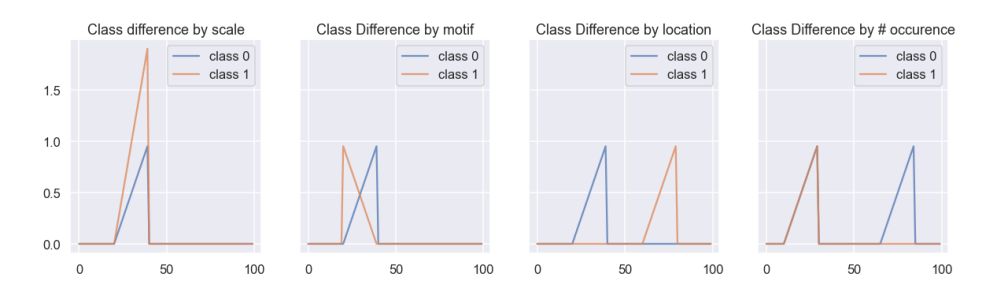

Looking back to the data frame, we see that the features aren't grouped nor ordered; we don't need to tell the classifier which features relate to which shapelet because it will learn these implicit relations during training. Shuffling the columns would have no impact on performance.

In [17]:
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import RDSTClassifier

rdst_lr = RDSTClassifier(
    estimator=LogisticRegression(max_iter=500),
    max_shapelets=10,
    save_transformed_data=True,
    shapelet_lengths=[9, 11, 13],
    random_state=99,
).fit(X_gun_train, y_gun_train)

While STC, by default, explores the whole possible range of shapelet lengths, for RDST it can be a good idea to restrict the lengths to give more room for dilation for the GunPoint problem. Lengths 9, 11, and 13 can be used following the convention set in the paper.

With our transformer (and classifier) fit, let's examine which 10 shapelets were extracted using RDST.

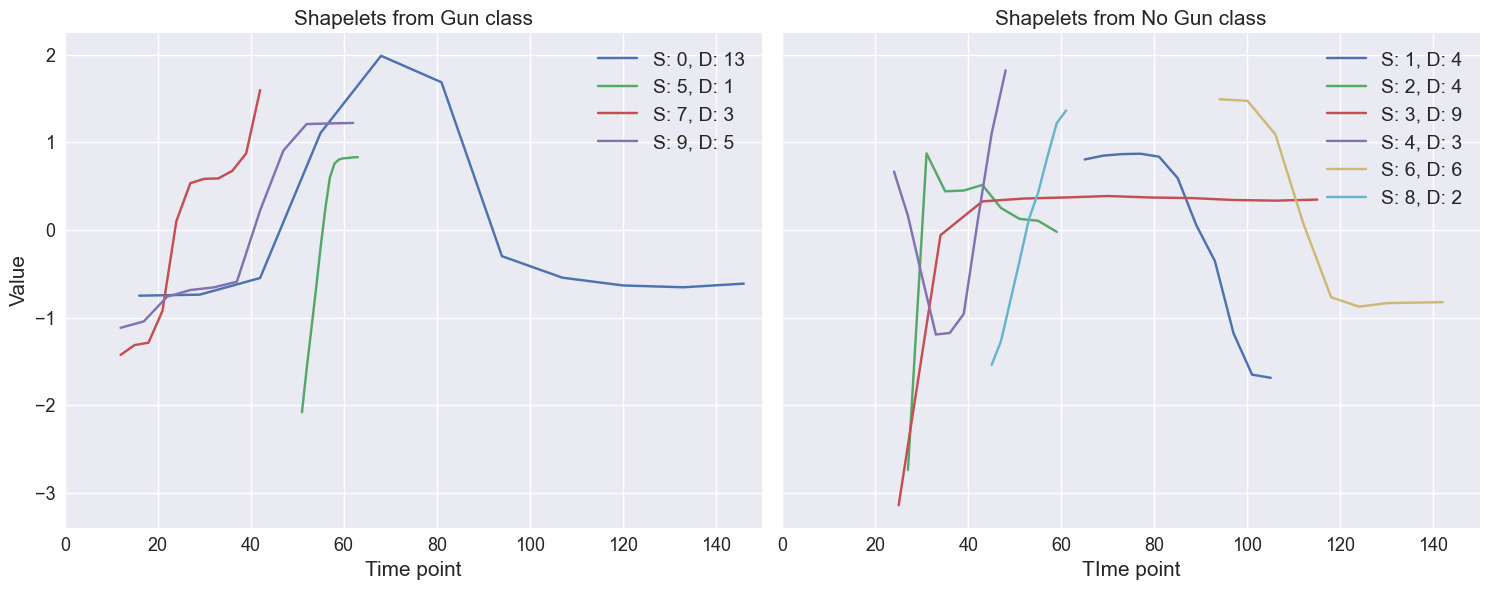

In [18]:
import matplotlib.pyplot as plt

shapelets_lr = rdst_lr._transformer.shapelets_
shapelet_vals_lr = shapelets_lr[0]
shapelet_pos_lr = shapelets_lr[1]
shapelet_dilation = shapelets_lr[3]
shapelet_classes = shapelets_lr[8]

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for idx, shapelet in enumerate(shapelet_vals_lr):
    dilation = shapelet_dilation[idx]
    startpoint = shapelet_pos_lr[idx]
    x_values = [startpoint + i * dilation for i in range(len(shapelet[0]))]

    if shapelet_classes[idx] == 0:
        axs[0].plot(x_values, shapelet[0], label=f"S: {idx}, D: {dilation}")
    else:
        axs[1].plot(x_values, shapelet[0], label=f"S: {idx}, D: {dilation}")


axs[0].set_title("Shapelets from Gun class")
axs[0].set_xlabel("Time point")
axs[0].set_ylabel("Value")
axs[0].legend()
axs[0].set_xlim(0, 150)

axs[1].set_title("Shapelets from No Gun class")
axs[1].set_xlabel("TIme point")
axs[1].legend()
axs[1].set_xlim(0, 150)

plt.tight_layout()
plt.show()

As you can see we have very different shapelets extracted with RDST. Some look jagged because of the dilation - comment out the random state parameter and run this cell a few times. The generated shapelets appear a little more chaotic because the shapelet candidate space is much larger and is no longer limited to contiguous subseries due to dilation. Using the same number of shapelet candidates (10,000) but in a larger space leads to more potential shapelets not being considered. This is the trade-off to maintain a degree of scalability; if you desire better accuracy, by all means, increase the max_shapelets parameter.

At this point, dilation does appear to harm interpretability since dilated shapelets are less familiar to domain experts and plotting them on top of time series often leads to them not fitting as perfectly as the other transforms. But we have more interpretable power through exploring both global and local patterns, as you'll see later.

In [19]:
import pandas as pd

from aeon.visualisation import ShapeletClassifierVisualizer

rdst_lr_vis = ShapeletClassifierVisualizer(rdst_lr)

rdst_lr_vis_index_0 = pd.Series(rdst_lr_vis._get_shp_importance(0)[0]).to_list()
rdst_lr_vis_index_1 = pd.Series(rdst_lr_vis._get_shp_importance(1)[0]).to_list()

elements_in_position = {
    "Rank": list(range(len(rdst_lr_vis_index_0))),
    "Logistic Regression classifier Gun": rdst_lr_vis_index_0,
    "Logistic Regression classifier No Gun": rdst_lr_vis_index_1,
}

df = pd.DataFrame(elements_in_position).set_index("Rank")
df

,Logistic Regression classifier Gun,Logistic Regression classifier No Gun
Rank,,
0,9,6
1,0,4
2,1,8
3,7,2
4,5,3
5,3,5
6,2,7
7,8,1
8,4,0


Ranking RDST shapelets is a bit trickier than ST because there are three separate features for each shapelet, we find a shapelet's importance by summing the importance of the three features corresponding to it.

Remember how distance is inversely correlated to the class? For simplicity, we assume that SO and argmin are directly correlated to it. However, in practice, too many appearances of a shapelet could mean it's too generic, and a larger argmin value just means that the shapelet occurred further down in the time series. Naturally, the trained classifier will find the most important distance features, so our crude estimation of importance can hold up.

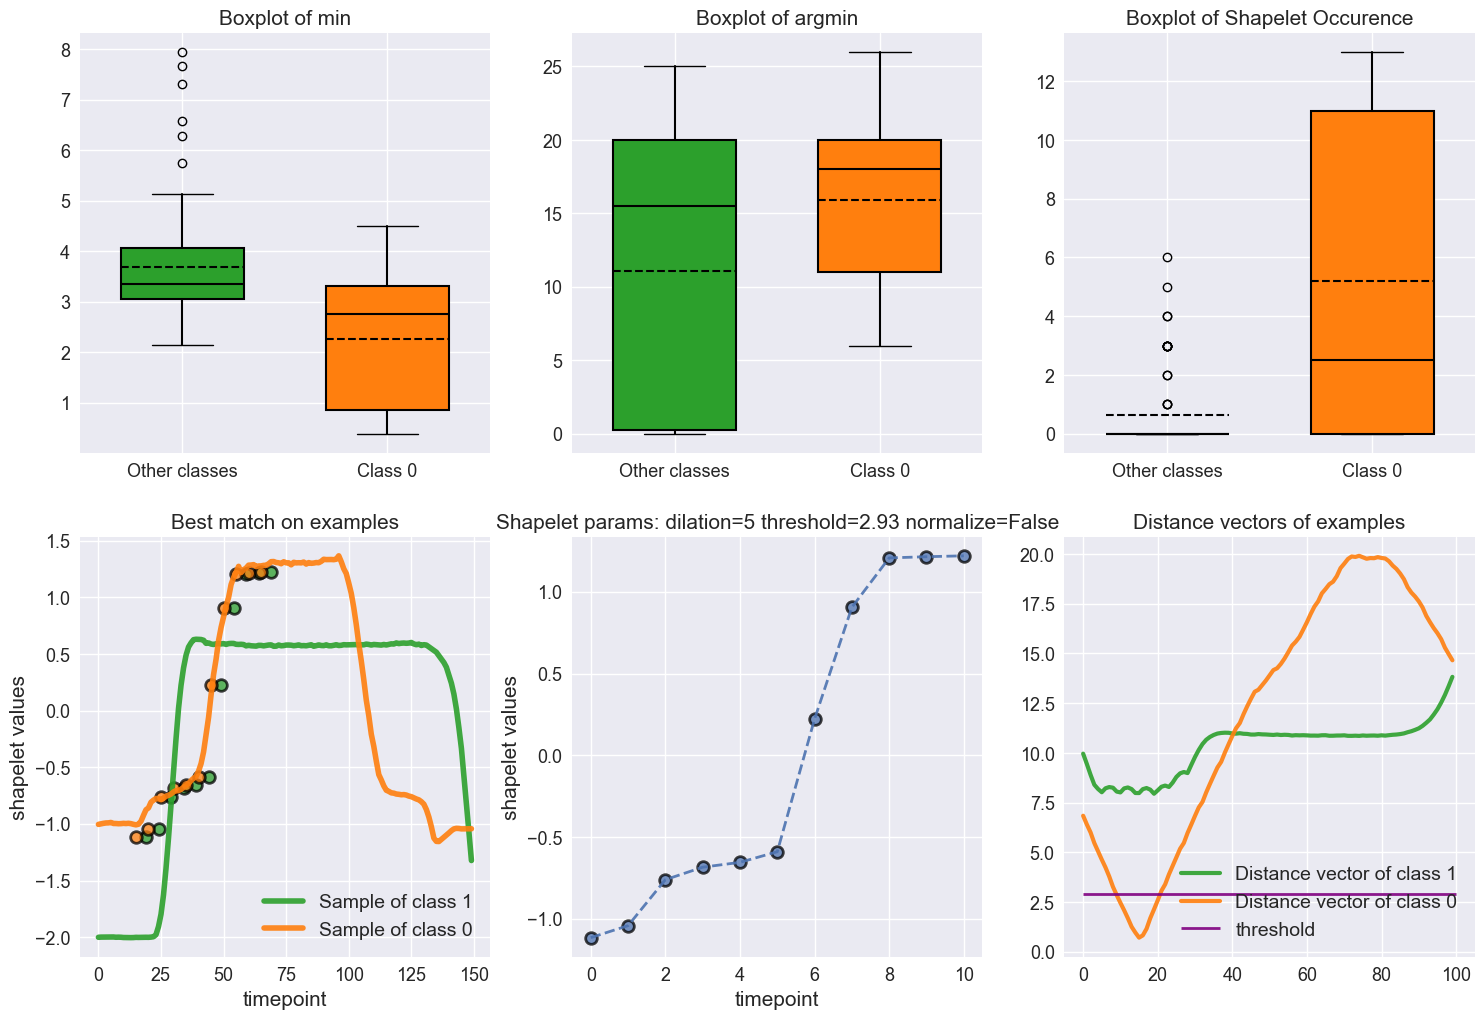

In [20]:
fig = rdst_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 3},
)

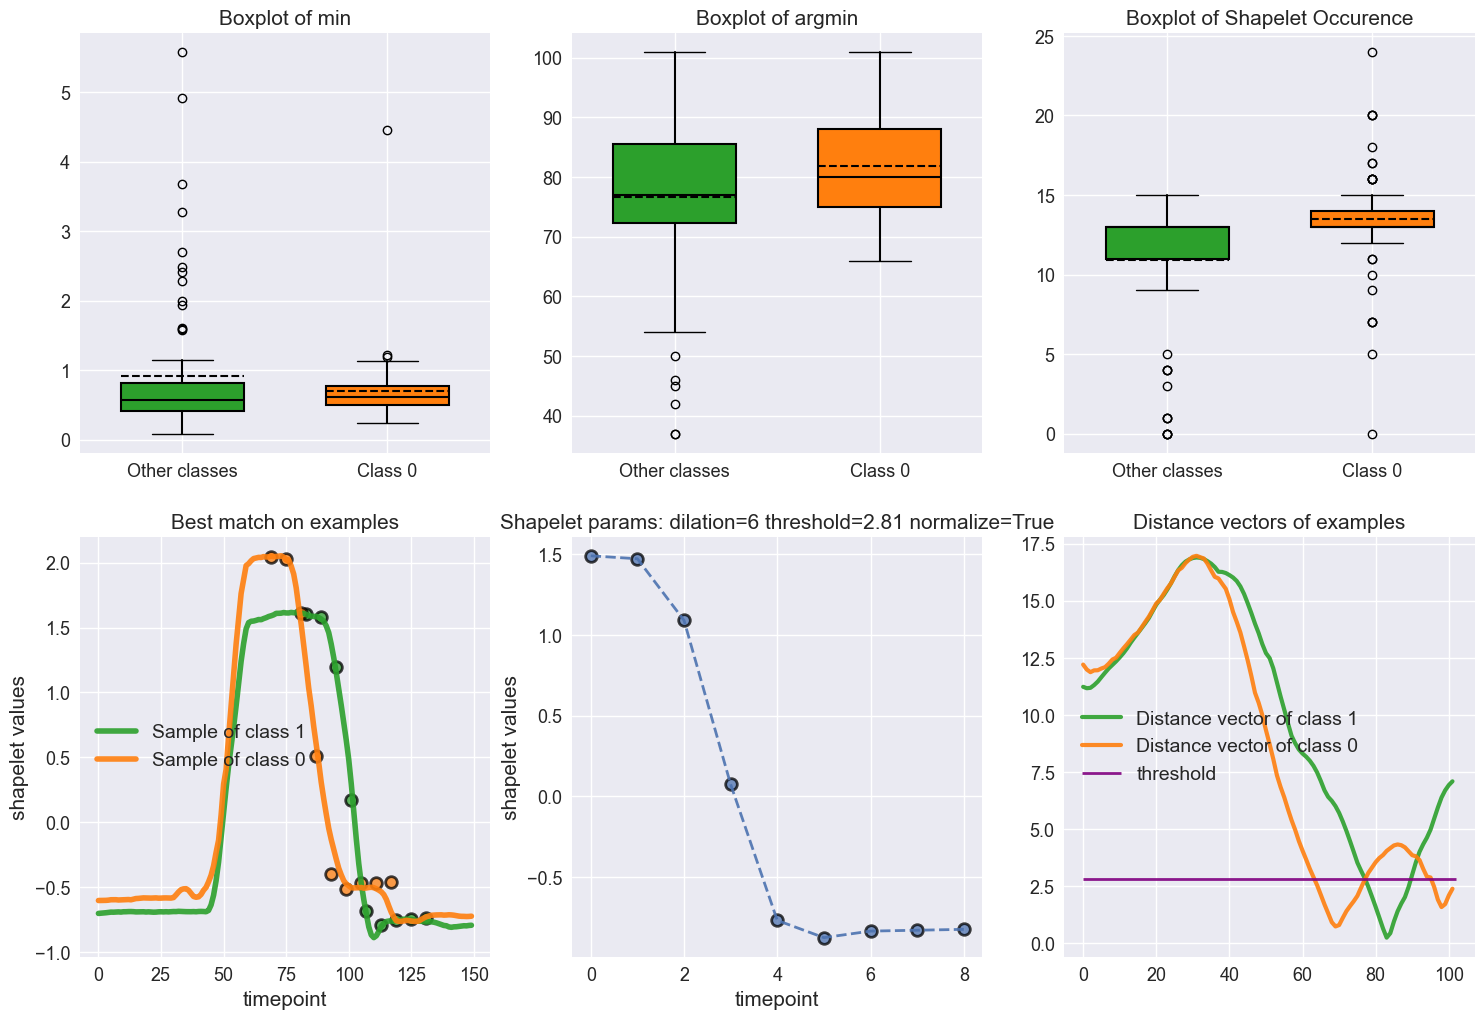

In [21]:
fig = rdst_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    best=False,  # This is best for No Gun
    id_example_class=10,
    id_example_other=4,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 3},
)

Look at that, we have even more angles to help us understand the Gunpoint problem.
These plots introduce three new pieces of information:
- A box plot of the best match positions for each class.
- A box plot of the number of occurrences for each class.
- The threshold value for accepting a subseries as a shapelet match.

We also get the see how the extracted shapelet looks prior to the dilation.

The above two plots show the best shapelet for each class according to the Logistic Regressor. Looking at the Shapelet Params graph (bottom middle), we can still distinguish the patterns described in the STC shapelets, the two-stage lift for Gun and the 'overshoot' for No Gun. However, I should admit that the dilation in this particular time series problem makes the interpretation a bit convoluted. Looking at the best No Gun shapelet, it is missing the critical 'overshoot' which leads to it fitting both classes pretty similarly; it is really thanks to the argmin & SO features that we can somewhat distinguish the two classes - the shapelet tends to fit the No Gun class earlier in the time series while occurring less often. The accuracy would be poor if the classification was based purely on this individual shapelet. Thankfully, the decisions were based on a conjunction of all 10 shapelets.

Suppose you consider dilation as a means of downsampling the data. The more abstract representation makes sense. In that case, these two shapelets capture the general pattern with less noise - making them more generalisable. For this problem, where the time series are relatively short and not recorded at a high frequency, there isn't much need to mitigate noise.

We can further understand the best Gun shapelet by using the additional box plots. We can see that the shapelet, pre-dilation, is extracted from the raise in two steps. Dilating it by 5 stretches this pattern out, allowing it to fit the different styles of the actors. It kind of enables a partial scale invariance in the x-axis. However, all this is useful only after analysing the box plots.

Initially, we see that the pattern fits the Gun class with quite some variance; this can be explained by the abstraction caused by the dilation. Curiously, after this level of abstraction, there is still a clear divide in fit between the two classes. This level of abstraction appears suitable for generalising to the Gun class while still not capturing the No Gun pattern. The shapelet still contains that 'step' in the middle of the raise.

We then learn that the shapelet is first found later than it is for the No Gun class; I speculate that's because it never truly fits the No Gun time series, so the best fit is as good as any. This idea is supported by the last box plot showing the SO distribution. The shapelet is never found for No Gun while being present up to 12 times for some Gun time series. If you recall the time series plot in my GunPoint article, the raise takes around 30 time points, so there is much room for the shapelet to closely match several times. Looking at the Distance vectors plot we see that, in this example, the 14 occurrences come in two clusters. I'm curious to experiment with changing SO to only count non-adjacent occurrences.
I think not normalising the shapelet gave it a more discriminative ability than the Gun shapelet, which is one of the benefits of RDST. It randomly assigns the normalisation parameter according to an input probability; you don't need to know what you seek in advance.

The fact that it's more straightforward to understand how it is the best for the Gun shapelet than the No Gun shapelet may suggest that it's more useful. It would make sense for the more interpretable shapelets to be more discriminative for ML algorithms. The RF ranked the No Gun shapelet as most useful in the last post; perhaps reinforcing that notion.

In [22]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from aeon.classification.shapelet_based import RDSTClassifier
from aeon.visualisation import ShapeletClassifierVisualizer

rdst_rf = RDSTClassifier(
    estimator=RandomForestClassifier(ccp_alpha=0.01),
    max_shapelets=10,
    save_transformed_data=True,
    shapelet_lengths=[9, 11, 13],
    random_state=99,
).fit(X_gun_train, y_gun_train)

rdst_rf_vis = ShapeletClassifierVisualizer(rdst_rf)

rdst_rf_vis_index_0 = pd.Series(rdst_rf_vis._get_shp_importance(0)[0]).to_list()

elements_in_position = {
    "Rank": list(range(len(rdst_rf_vis_index_0))),
    "Random Forest Ranking": rdst_rf_vis_index_0,
}

df = pd.DataFrame(elements_in_position).set_index("Rank")
df

,Random Forest Ranking
Rank,
0,9
1,2
2,5
3,8
4,0
5,4
6,3
7,7
8,6


Cross referencing the shapelet to its label we see that it is shapelet 6…

Look at that! It is the 2nd worst shapelet according to the RF.

#### Scalable and Accurate Subsequence Transform

In [23]:
import time

from aeon.transformations.collection.shapelet_based import SAST

start_time = time.time()
sast = SAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Show the elapsed transform time
sast_elapsed_time = end_time - start_time
print(f"Time taken to fit: {sast_elapsed_time:.4f} seconds")

pd.DataFrame(sast.transform(X_gun_test))

Time taken to fit: 0.1421 seconds


,0,1,2,3,4,5,6,7,8,9,...,22040,22041,22042,22043,22044,22045,22046,22047,22048,22049
0,2.139313e-04,3.501401e-08,0.000068,0.000036,3.248359e-04,0.000020,0.003587,0.001489,0.000150,0.003110,...,51.745296,51.768120,51.833286,68.707420,68.727066,68.731049,51.980789,52.003918,69.060715,69.071503
1,5.475935e-04,4.410312e-04,0.000684,0.000745,8.177264e-04,0.006539,0.001422,0.000080,0.000171,0.005529,...,7.186250,7.186410,7.430910,13.950408,9.316195,6.015170,7.227113,7.472096,14.007667,9.354983
2,9.576424e-05,9.937883e-05,0.000008,0.000745,7.953599e-07,0.000364,0.009840,0.000939,0.002092,0.061477,...,170.467758,170.625931,170.773636,191.134140,190.962784,190.771957,170.700500,170.852707,191.583649,191.394150
3,1.445529e-08,2.147003e-03,0.001580,0.000105,1.674776e-03,0.007586,0.000101,0.010818,0.000001,0.002244,...,33.433865,34.152340,35.303265,46.634243,46.636833,46.927536,34.263298,35.416946,46.875660,47.170082
4,4.638288e-06,3.071507e-04,0.000021,0.001371,1.674776e-03,0.001746,0.000041,0.000830,0.000008,0.004280,...,1.013976,0.423975,0.427198,21.461655,15.568135,10.701016,1.020511,0.428486,21.543852,15.626773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,4.845147e-06,2.389025e-03,0.000489,0.002455,1.674776e-03,0.002396,0.000022,0.003484,0.000887,0.019164,...,23.643301,17.784300,13.139985,62.376740,51.786152,41.978596,23.767502,17.885603,62.653515,52.017059
146,3.252499e-06,1.881394e-03,0.000270,0.000745,1.674776e-03,0.021296,0.017314,0.004592,0.000152,0.006416,...,10.657029,16.192657,22.701468,3.965507,4.338061,6.069705,16.241095,22.769346,4.365573,6.104211
147,2.376808e-05,6.231621e-03,0.003538,0.000008,1.674776e-03,0.000632,0.000801,0.006775,0.000032,0.006432,...,2.147891,2.528433,4.221993,7.013851,4.425121,3.243526,2.536044,4.234569,7.043352,4.444687
148,9.985268e-08,1.721297e-04,0.000504,0.000745,7.840089e-04,0.000098,0.010583,0.000253,0.000011,0.000001,...,101.014694,101.041275,101.067039,129.962738,130.487579,130.926315,101.241676,101.268707,130.896133,131.340866


SAST first randomly selects 1 time series, by default, from each class (they are called reference time series). Then, SAST generates all the subsequences of the specified lengths from these reference time series. So, all lengths from every starting point. These subsequences are then used to transform a time series dataset, replacing each time series with its distance vector to each subsequence.

Unlike the previous two transforms, SAST doesn’t select the best subseries, so we need to choose 10 to visualise ourselves before we plot.

In [24]:
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import SASTClassifier

sast_lr = SASTClassifier(
    classifier=LogisticRegression(),
    seed=0,
    nb_inst_per_class=10,
).fit(X_gun_train, y_gun_train)

We need to fit the SAST classifier to obtain the Logistic Regressor’s feature rankings. Rather than only using one reference time series, 10 will drive extra insight. In the case where subsampling completely
removes one actor from the training data, the performance on the test set, where the two
actors are present, could be reduced.

In [25]:
from operator import itemgetter

feature_importance = abs(sast_lr._pipeline[-1].coef_[0])

subseries = sast_lr._transformer._kernel_orig
norm_subseries = sast_lr._transformer._kernels
start_pos = sast_lr._transformer._start_points
classes = sast_lr._transformer._classes
time_series_indexes = sast_lr._transformer._source_series
# Combine shapelets with their feature importance, start positions, and class info
features = zip(
    subseries,
    norm_subseries,
    feature_importance,
    start_pos,
    classes,
    time_series_indexes,
)

# Sort features by importance (descending order)
sorted_features = sorted(features, key=itemgetter(2), reverse=True)

# Extract sorted shapelets, start positions, and class info
subseries = [feature[0] for feature in sorted_features]
norm_subseries = [feature[1] for feature in sorted_features]
start_positions = [feature[3] for feature in sorted_features]
shapelet_classes = [feature[4] for feature in sorted_features]
time_series_indices = [feature[5] for feature in sorted_features]
shapelet_lengths = [len(feature[0]) for feature in sorted_features]

num_shapelets = 10
# Get the top 10 shapelets with their start positions and class information
top_subseries = [
    (subseries, norm_subseries, start_pos, cls)
    for subseries, norm_subseries, start_pos, cls in zip(
        subseries, norm_subseries, start_positions, shapelet_classes
    )
]
shapelets = top_subseries[:num_shapelets]

Now we can select the top 10 shapelets. Those which are most strongly correlated to each class.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


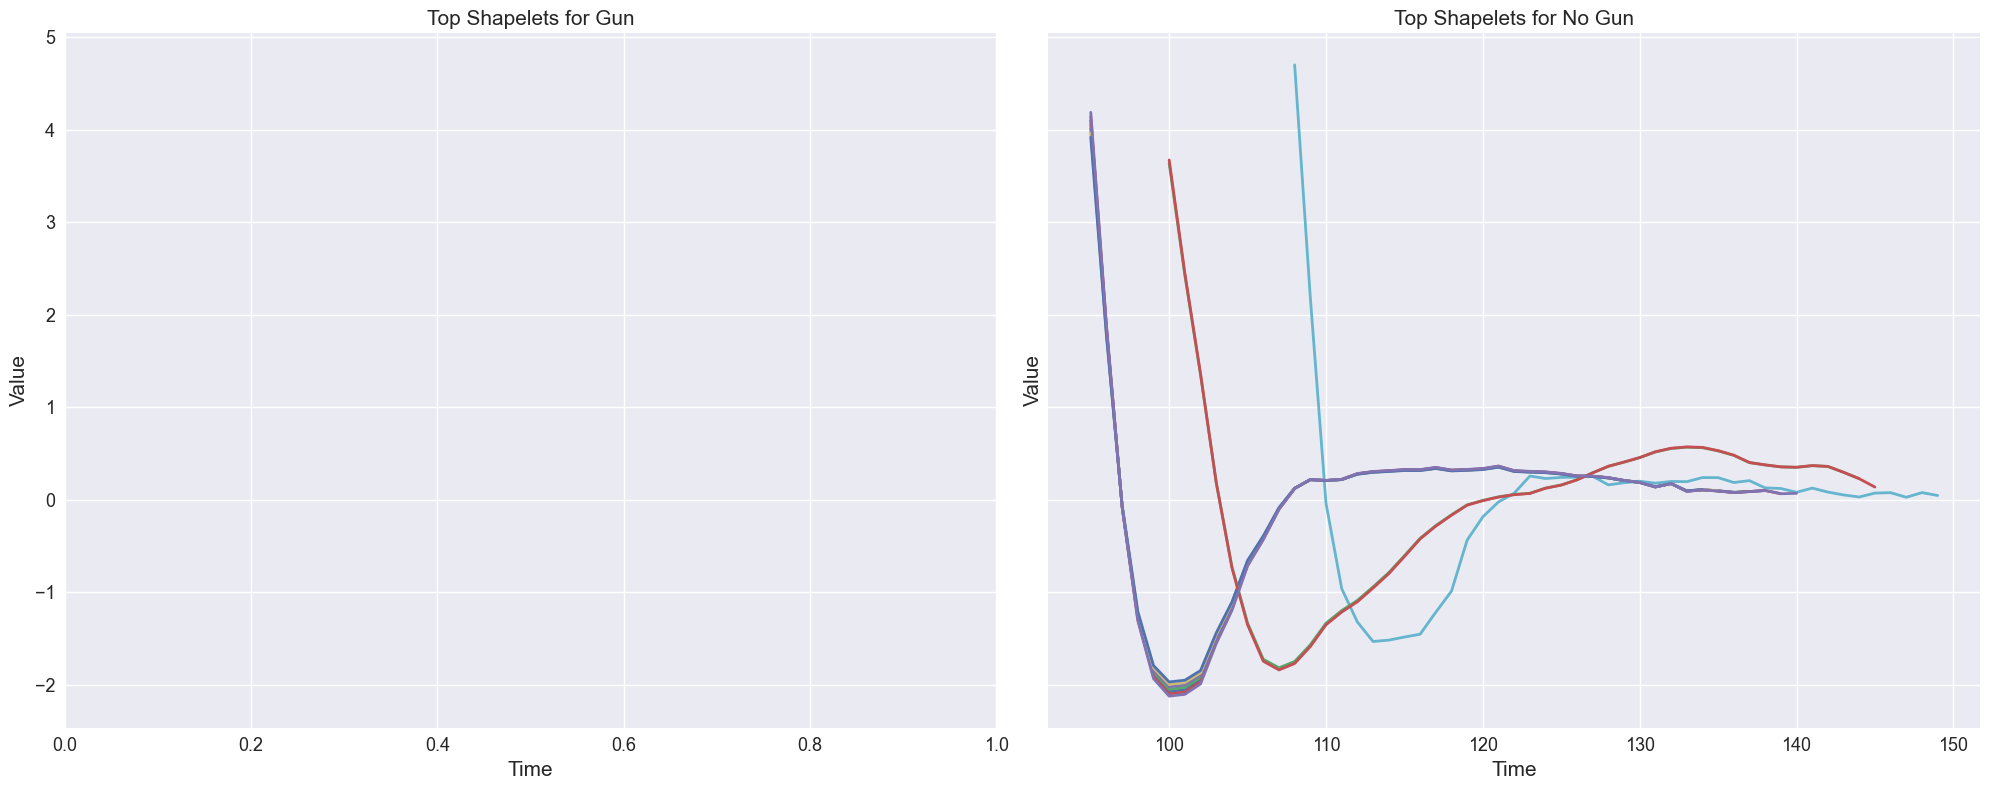

In [26]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Gun
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Gun")
axes[0].legend()
axes[0].grid(True)

# Plot shapelets for No Gun
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for No Gun")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Unlike before, we aren’t plotting the original shapelets but the shapelets once they’re normalised. Visualising them wouldn’t be helpful because many of them come from the same time series; there would be much overlap. Instead, the normalised version shows us the specific patterns the shapelet represents. It lets us distinguish each individual shapelet in our following plot. Also, SAST uses the normalised shapelet for the distance computations, so it’s appropriate to see them in this form.

Looking at the shapelet plot, we learn that the 10 best shapelets from SAST are all from the No Gun class and appear to be coming from three out of the ten reference time series at around the same point with a roughly similar length. Let’s verify this by summarising their characteristics in a table.

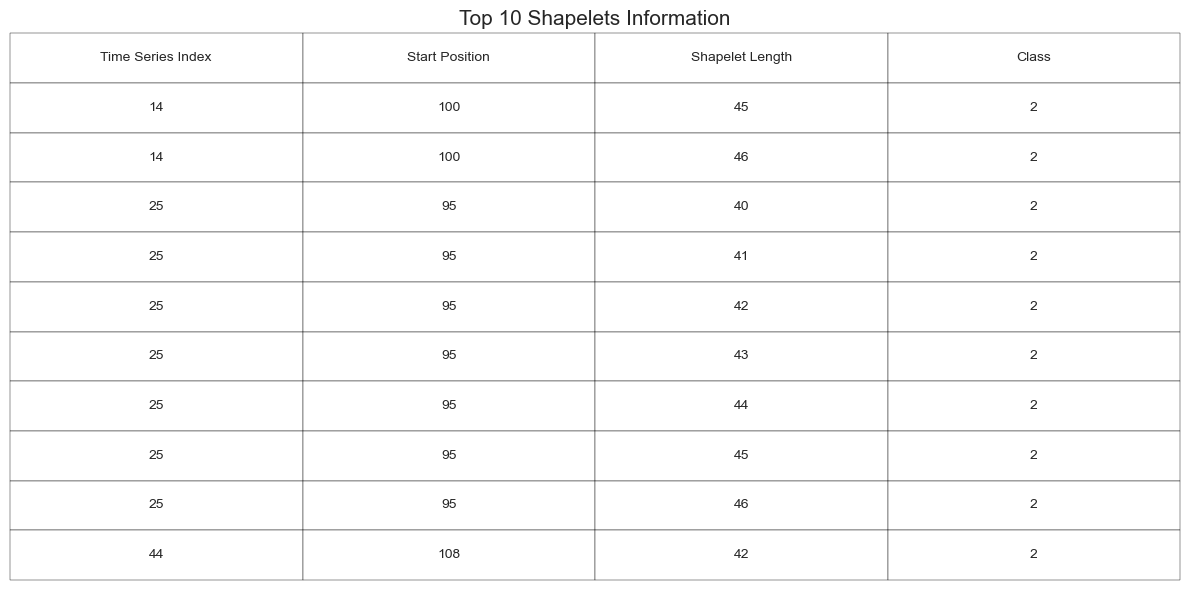

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the top 10 shapelets
data = {
    "Time Series Index": time_series_indices[:num_shapelets],
    "Start Position": start_positions[:num_shapelets],
    "Shapelet Length": shapelet_lengths[:num_shapelets],
    "Class": shapelet_classes[:num_shapelets],  # New column for shapelet classes
}
df = pd.DataFrame(data)

# Define the priority order for sorting
priority_order = ["Time Series Index", "Start Position", "Shapelet Length", "Class"]

# Sort the DataFrame by the priority columns
df_sorted = df.sort_values(by=priority_order, ascending=True)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
ax.axis("off")  # Hide the axis

# Create the table
table = ax.table(
    cellText=df_sorted.values,
    colLabels=df_sorted.columns,
    cellLoc="center",
    loc="center",
    bbox=[0, 0, 1, 1],
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(df_sorted.columns)

plt.title("Top 10 Shapelets Information")
plt.tight_layout()
plt.show()

Yes, just as we thought.

The first of the stwo figures show the importance of scale & phase invariance in the shapelets; we can see that they all share the pattern, just at different heights & points in time.

SAST has provided us with a new insight into GunPoint. However, it feels contradictory to the findings from the past two transforms. Given how similar all 10 shapelets are in position & length, this problem only has one particularly correlated pattern — the overshoot found in No Gun. You may wonder where those shapelets that we previously discovered from to the Gun class lie…

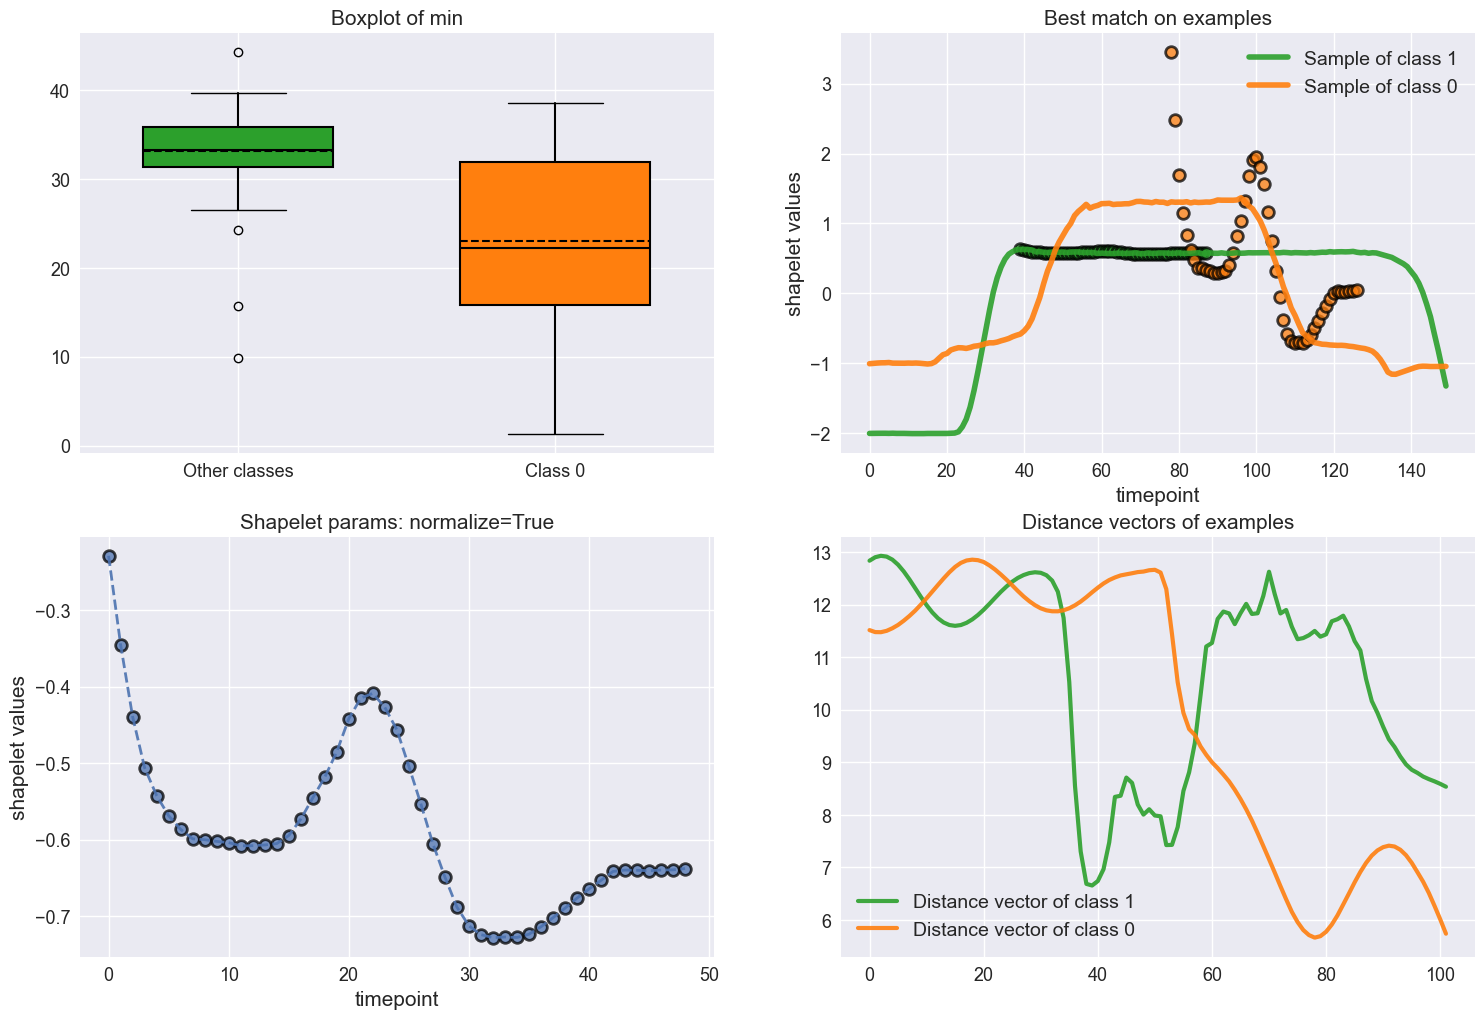

In [28]:
sast_lr_vis = ShapeletClassifierVisualizer(sast_lr)

fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

Why doesn’t this look familiar? Shouldn’t it show a two step ascent?

Looking at the boxplot of min (top left plot), the distance distribution for Gun has variance and overlaps with the other class. Technically, we can’t call this a shapelet since it isn’t highly discriminative. So, let’s not focus on it for now; it won’t give us any insight like the previous examples. Looks like, SAST didn’t find (or doesn’t agree with) the two-step raise being discriminative to the Gun class.

In [29]:
# Filter shapelets by class
best_class_one_shp = [
    (shapelet, start_pos, index)
    for index, (shapelet, start_pos, cls) in enumerate(
        zip(top_subseries, start_positions, shapelet_classes)
    )
    if cls == "1"
][0]

print("Best class one shapelet is ranked", best_class_one_shp[2])

Best class one shapelet is ranked 357


According to SAST, there are 356 more strongly correlated shapelets from the No Gun class. This is a little misleading because SAST does not have an equivalent to eliminating self-similar shapelets like ST and RDST. Nevertheless, We can question our previous theory, that the Gun shapelets are more important. Despite this small obstacle in our reasoning, atleast we are still encountering the recurring theme that the two classes are distinguished during the descent. Let’s see if the (not-so-great) Gun shapelet still looks the same as what we have seen up until now.

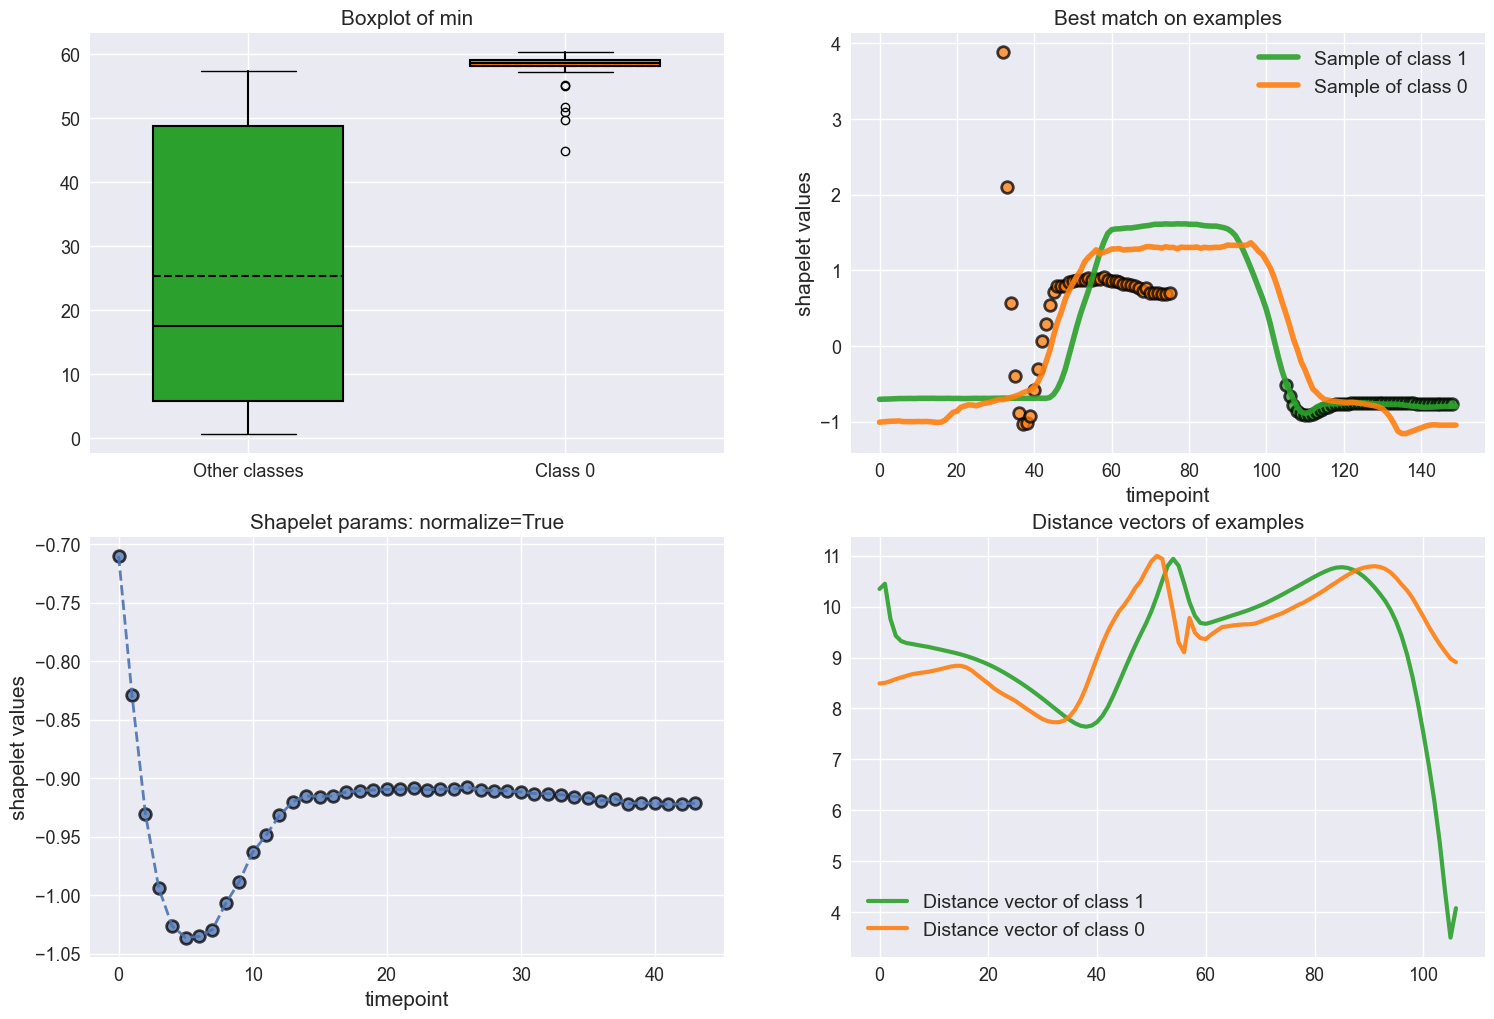

In [30]:
fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,  # Gun
    best=False,  # Will show best No Gun
    id_example_class=1,
    id_example_other=4,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

Looking at the boxplot of min plot, this shapelet consistently fits the the Gun class much worse than the No Gun class. The variance in the No Gun class can be caused by noise, such as the fact that there are two different actors with different styles. Still, we can be confident that ‘overshoot’ doesn’t occur for the Gun class; especially when seeing the ‘best’ match on the Gun class, it is entirely in the wrong place and is only considered a fit because normalisation reveals that the flat datapoints following the dip are similar to when the actor holds the gun in place while pointing.

#### Random and Scalable Subsequence Transform

In [31]:
import time

from aeon.transformations.collection.shapelet_based import RSAST

start_time = time.time()
rsast = RSAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
rsast_elapsed_time = end_time - start_time
print(f"Time taken to fit: {rsast_elapsed_time:.4f} seconds")

Time taken to fit: 1.9341 seconds


In [32]:
pd.DataFrame(rsast.transform(X_gun_test))

,0,1,2,3,4,5,6,7,8,9,...,4130,4131,4132,4133,4134,4135,4136,4137,4138,4139
0,8.519215e-04,0.008358,7.290993e-06,0.000111,0.003317,0.000068,7.000024e-05,2.395120e-05,3.205474e-04,0.007157,...,1.211195,25.986052,18.136734,0.626053,42.861858,0.814035,0.151063,28.223389,1.219209,69.542137
1,1.910680e-03,0.000034,4.786369e-07,0.000061,0.000032,0.000052,3.113676e-05,3.755584e-04,1.085462e-06,0.000001,...,43.165359,79.876152,60.023304,41.848270,87.301117,49.898094,11.364259,62.058487,53.563335,75.924889
2,1.172140e-04,0.002710,5.913218e-04,0.000048,0.000066,0.000074,2.549383e-05,3.222681e-03,6.190102e-04,0.002046,...,0.803016,17.859095,21.182997,0.362200,28.431465,0.608107,23.208269,32.520302,0.827374,68.766129
3,7.327784e-06,0.012742,1.385944e-06,0.000001,0.000028,0.000008,9.877854e-06,9.258422e-06,3.118578e-05,0.011458,...,1.853201,34.085129,20.118050,1.059869,50.143997,2.129591,0.172761,32.319523,3.035327,68.168533
4,5.372230e-04,0.010393,1.301677e-04,0.000135,0.000027,0.000007,3.037888e-06,2.708665e-08,3.102947e-04,0.011830,...,35.638805,72.771339,57.600861,31.108198,80.853958,39.166485,5.762286,60.536930,42.915443,83.004364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,7.626676e-07,0.000108,1.793600e-04,0.000087,0.003547,0.000011,2.933095e-05,1.883393e-05,2.057106e-03,0.000296,...,40.601994,76.908562,56.099190,38.271843,84.404556,46.300068,9.466982,60.769855,49.841831,75.289307
146,1.165337e-03,0.000079,1.655183e-05,0.000999,0.000211,0.000002,1.640537e-04,5.961328e-05,1.527198e-07,0.000248,...,29.814108,66.996254,54.375557,26.290726,75.521729,34.195660,3.129634,61.198570,37.650204,86.276611
147,3.399473e-04,0.001168,2.136406e-06,0.002604,0.000066,0.000168,3.914161e-05,1.424414e-03,1.064065e-04,0.000748,...,24.028500,59.375103,47.198635,20.971251,69.526871,28.058716,2.430321,55.523331,31.186111,81.064613
148,3.020782e-05,0.000038,1.103533e-04,0.000256,0.000037,0.000832,7.859333e-07,6.711456e-06,3.254130e-04,0.000041,...,1.094907,21.511637,16.483072,0.433406,36.611584,0.723025,0.201245,24.586658,1.005772,70.770721


First of all, RSAST extracts five times less subseries. Remember how all the shapelets came from around the same place and were of a similar length? Using statistical methods RSAST reduces this redundancy, rather than conducting an exhaustive search for the candiate shapelets within the reference timeseries.

In [33]:
from sklearn.linear_model import LogisticRegression

from aeon.classification.shapelet_based import RSASTClassifier

rsast_lr = RSASTClassifier(
    classifier=LogisticRegression(),
    seed=0,
    nb_inst_per_class=10,
).fit(X_gun_train, y_gun_train)

In [34]:
from operator import itemgetter

feature_importance = abs(rsast_lr._pipeline[-1].coef_[0])

subseries = rsast_lr._transformer._kernel_orig
norm_subseries = rsast_lr._transformer._kernels
start_pos = rsast_lr._transformer._start_points
classes = rsast_lr._transformer._classes
time_series_indexes = rsast_lr._transformer._source_series
# Combine shapelets with their feature importance, start positions, and class info
features = zip(
    subseries,
    norm_subseries,
    feature_importance,
    start_pos,
    classes,
    time_series_indexes,
)

# Sort features by importance (descending order)
sorted_features = sorted(features, key=itemgetter(2), reverse=True)

# Extract sorted shapelets, start positions, and class info
subseries = [feature[0] for feature in sorted_features]
norm_subseries = [feature[1] for feature in sorted_features]
start_positions = [feature[3] for feature in sorted_features]
shapelet_classes = [feature[4] for feature in sorted_features]
time_series_indices = [feature[5] for feature in sorted_features]
shapelet_lengths = [len(feature[0]) for feature in sorted_features]

num_shapelets = 10
# Get the top 10 shapelets with their start positions and class information
top_subseries = [
    (subseries, norm_subseries, start_pos, cls)
    for subseries, norm_subseries, start_pos, cls in zip(
        subseries, norm_subseries, start_positions, shapelet_classes
    )
]
shapelets = top_subseries[:num_shapelets]

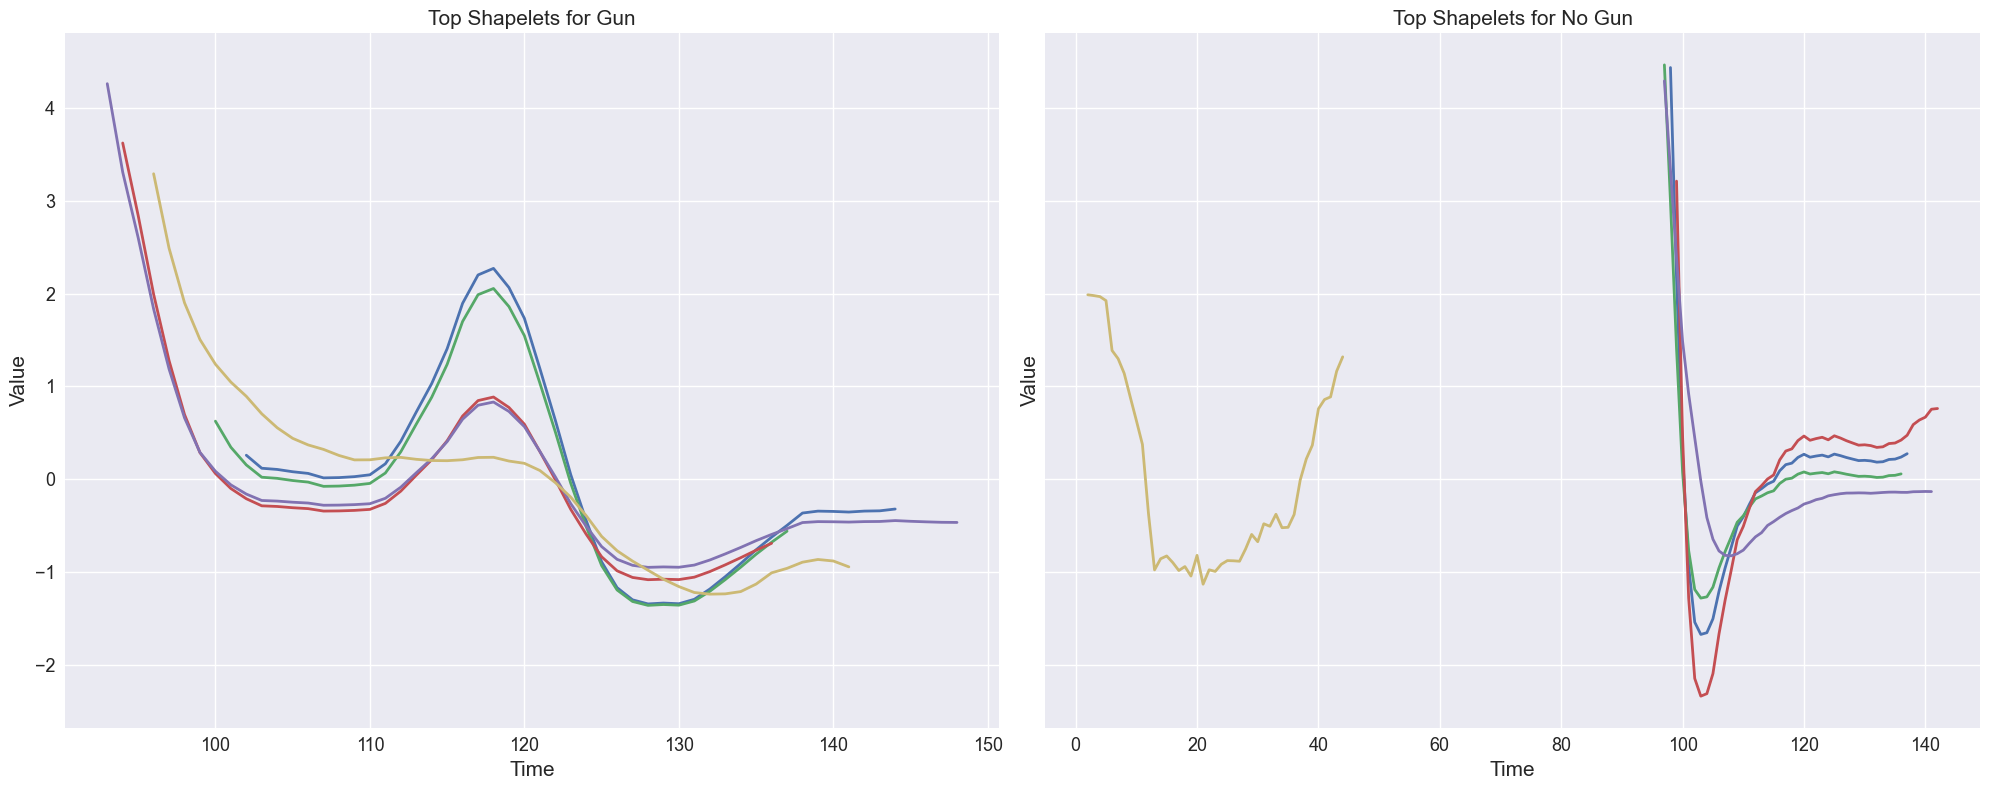

In [35]:
import matplotlib.pyplot as plt

# Separate the shapelets by class
class_1_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "1"
]
class_2_shapelets = [
    (norm_shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot shapelets for Class 1
for i, (shapelet, start_pos) in enumerate(class_1_shapelets, start=1):
    axes[0].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 1 Shapelet {i}",
        linewidth=2,
    )
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Top Shapelets for Gun")
axes[0].grid(True)

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    axes[1].plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")
axes[1].set_title("Top Shapelets for No Gun")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Like for SAST we aren't plotting the original shapelets but the shapelets once theyre normalised.

The 10 shapelets for RSAST are evenly split between the two classes. They mostly look familiar, those from Gun we were recently introduced to by SAST and the 4 from the No Gun class we have repeatedly encountered and termed ‘overshoot’. It looks like those Gun shapelets are found during the descent of the movement, maybe they are representing the actor putting the gun back into the holster.

One funky-looking shapelet is left from the start of a No Gun time series.

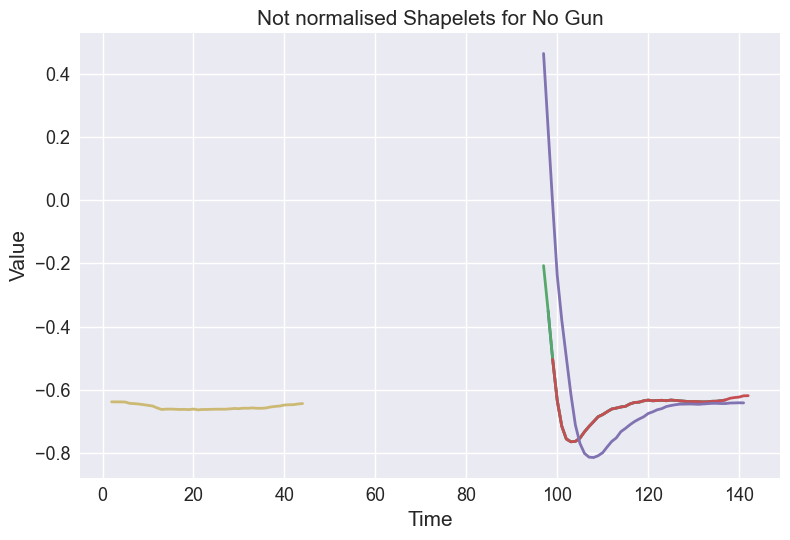

In [36]:
import matplotlib.pyplot as plt

class_2_shapelets = [
    (shapelet, start_pos)
    for shapelet, norm_shapelet, start_pos, cls in shapelets
    if cls == "2"
]

# Plot shapelets for Class 2
for i, (shapelet, start_pos) in enumerate(class_2_shapelets, start=1):
    plt.plot(
        range(start_pos, start_pos + len(shapelet)),
        shapelet,
        label=f"Class 2 Shapelet {i}",
        linewidth=2,
    )
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Not normalised Shapelets for No Gun")
plt.grid(True)

plt.tight_layout()
plt.show()

Looking at the same No Gun shapelets exactly as they appear in their reference time series (prior to normalisation), the funky gold shapelet is easier to understand. There may be a very subtle difference in the movement of the actors’ arm before raising it. However, this is more likely an artefact of stratified sampling.

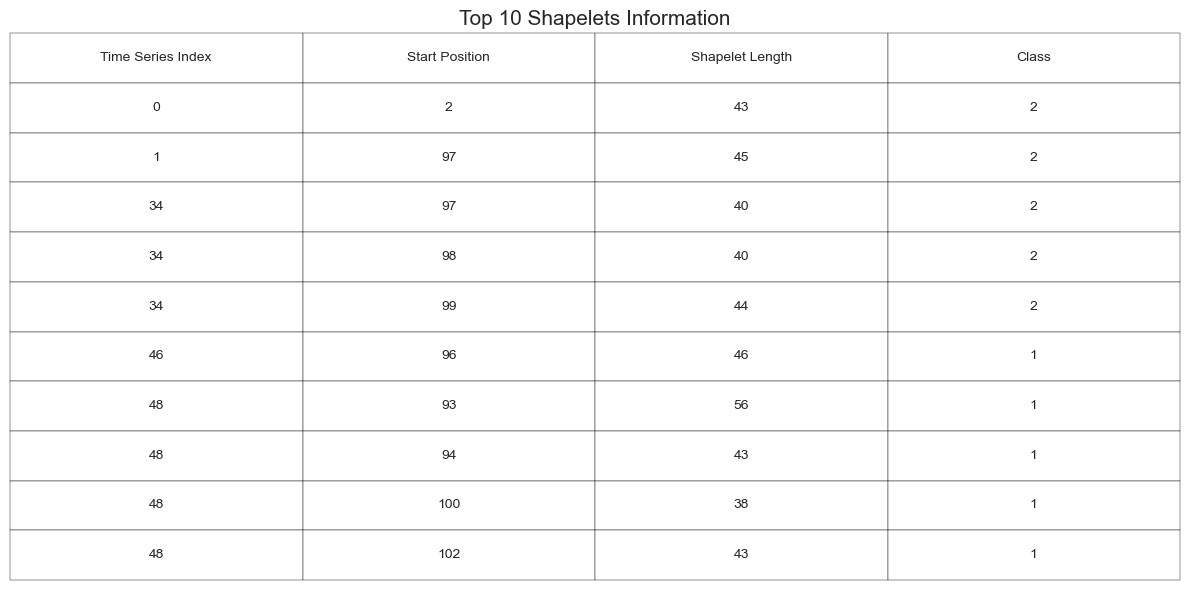

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for the top 10 shapelets
data = {
    "Time Series Index": time_series_indices[:num_shapelets],
    "Start Position": start_positions[:num_shapelets],
    "Shapelet Length": shapelet_lengths[:num_shapelets],
    "Class": shapelet_classes[:num_shapelets],  # New column for shapelet classes
}
df = pd.DataFrame(data)

# Define the priority order for sorting
priority_order = ["Time Series Index", "Start Position", "Shapelet Length", "Class"]

# Sort the DataFrame by the priority columns
df_sorted = df.sort_values(by=priority_order, ascending=True)

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed
ax.axis("off")  # Hide the axis

# Create the table
table = ax.table(
    cellText=df_sorted.values,
    colLabels=df_sorted.columns,
    cellLoc="center",
    loc="center",
    bbox=[0, 0, 1, 1],
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(df_sorted.columns)

plt.title("Top 10 Shapelets Information")
plt.tight_layout()
plt.show()

Interestingly, only five of the ten reference time series provided shapelets, and neither class shares the same reference time series. Time series 34 and 48 appear most frequently, implying that they best represent each class. That gold funky shapelet from the start of the No Gun movement comes from a reference time series appearing only once; my confidence in this being an artefact is growing.

As in SAST, we again see that most shapelets come from a similar start point and have similar lengths. They are all slight variations of the same pattern; maybe we could get away with using just one shapelet.

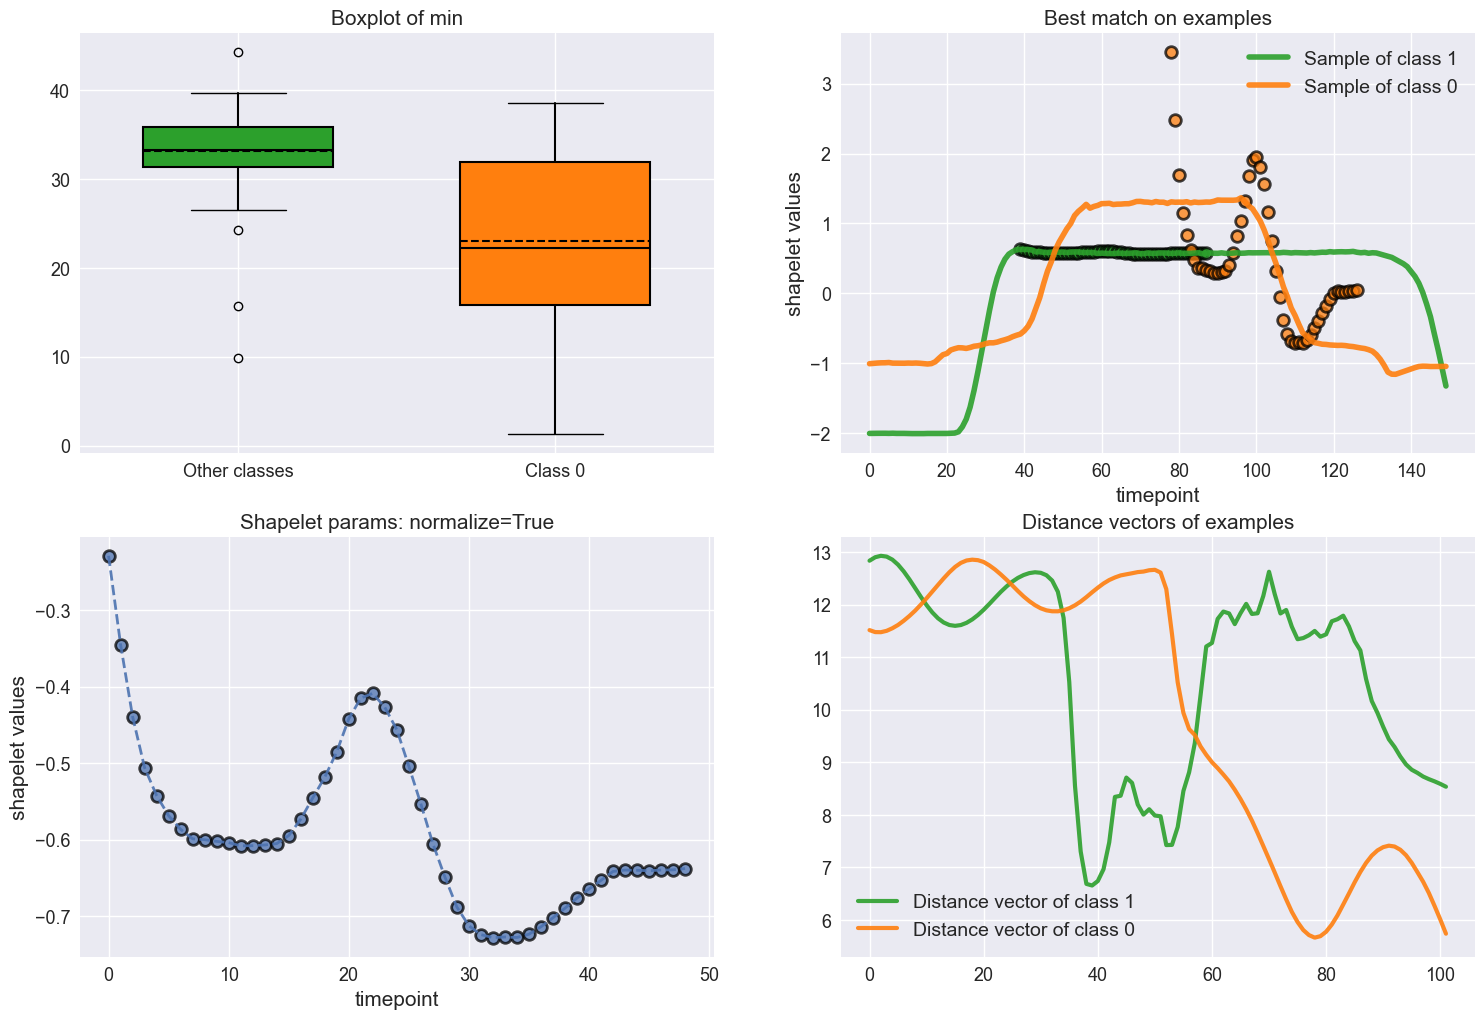

In [38]:
sast_lr_vis = ShapeletClassifierVisualizer(sast_lr)

fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    id_example_class=1,
    id_example_other=1,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

In [39]:
# Filter shapelets by class
best_class_one_shp = [
    (shapelet, start_pos, index)
    for index, (shapelet, start_pos, cls) in enumerate(
        zip(top_subseries, start_positions, shapelet_classes)
    )
    if cls == "1"
][0]

print("Best class one shapelet is ranked", best_class_one_shp[2])

Best class one shapelet is ranked 3


The same shapelet from SAST has crept up again only its considered to be in the top 10 thanks to RSAST's stratified sampling.

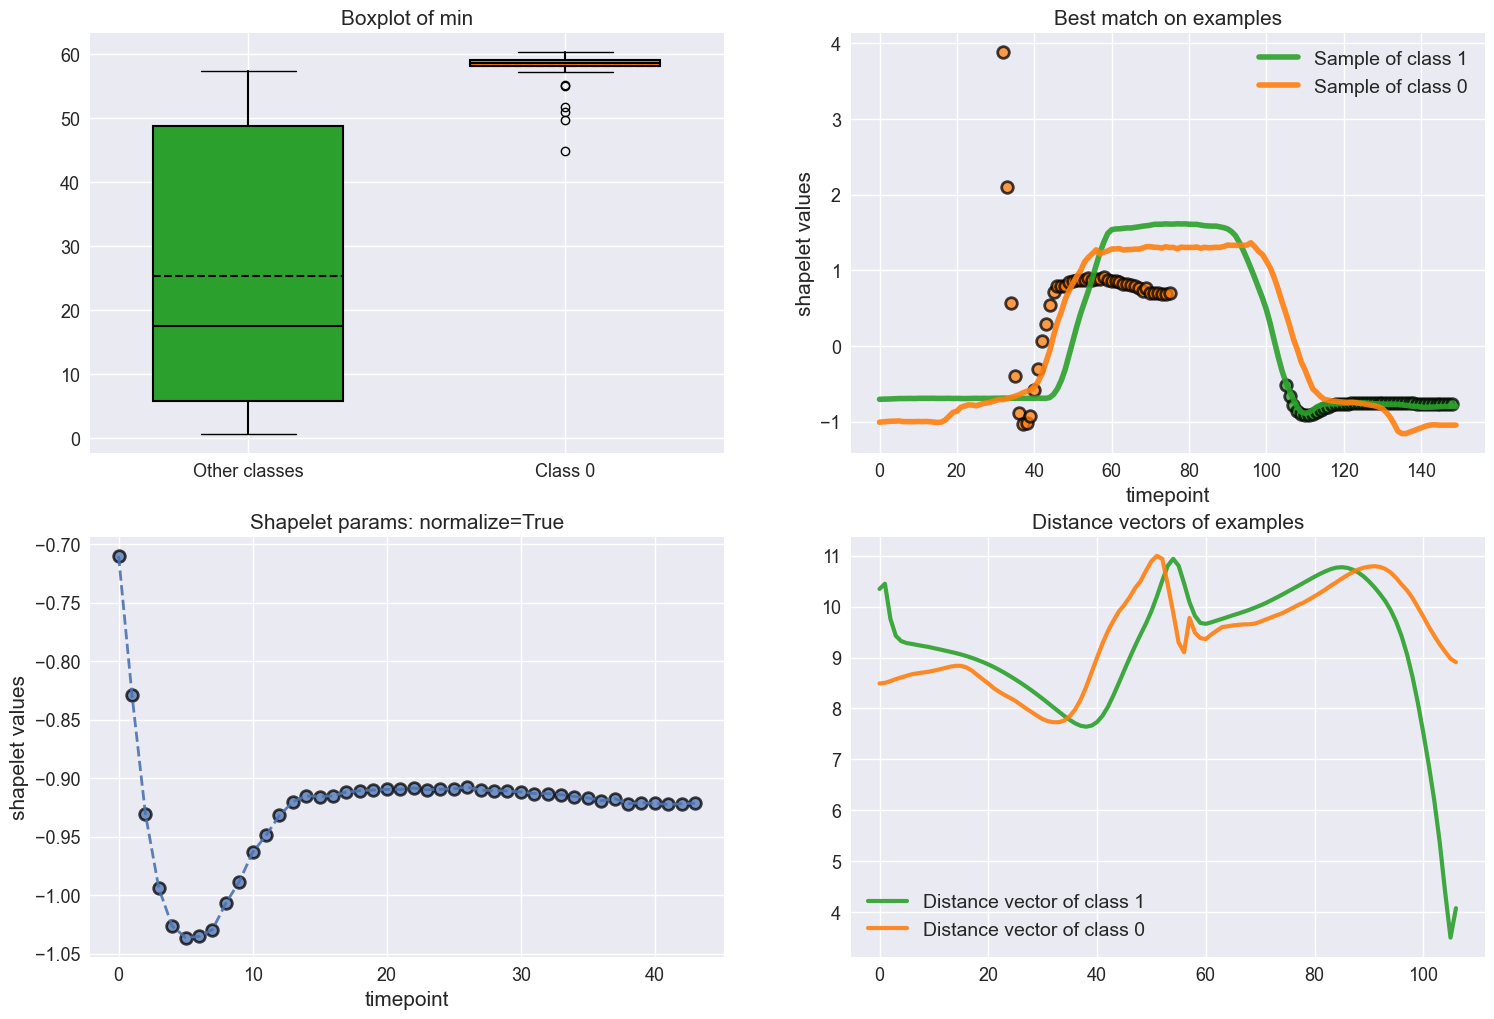

In [40]:
sast_lr_vis = ShapeletClassifierVisualizer(sast_lr)

fig = sast_lr_vis.visualize_shapelets_one_class(
    X_gun_test,
    y_gun_test,
    0,
    best=False,
    id_example_class=1,
    id_example_other=4,
    figure_options={"figsize": (18, 12), "nrows": 2, "ncols": 2},
)

The plots for the best shapelet for each class for RSAST are the same as for SAST, giving us no new insights — other than that funky shapelet not being the best for No Gun. We can conclude it was an artefact.

# What we've learned

Talk about shapelet extraction times. Summarise the types of shapelets found, and go over the ways to interpret.

In [42]:
time_values = {
    "RST": rst_elapsed_time,
    "RDST": rdst_elapsed_time,
    "SAST": sast_elapsed_time,
    "RSAST": rsast_elapsed_time,
}

print(f"{'Transformer':<10} | {'Value'}")
print("-" * 45)

for transformer, time_value in time_values.items():
    time_var = f"{transformer.lower()}_time"
    print(f"{transformer:<10} |  {time_value}")

Transformer | Value
---------------------------------------------
RST        |  13.958854913711548
RDST       |  73.46805095672607
SAST       |  0.1421210765838623
RSAST      |  1.93412446975708


Time to wrap up our exploration of GunPoint. Using only information available in the dataset, we developed an expert-level understanding of the problem. The GunPoint example is intuitive and doesn’t require domain knowledge. Still, it helps us show the power of shapelets which could help us understand more intricate scenarios.

The **shapelet transform** perfectly highlighted the value of shapelets. It directed our focus to the raise and descent parts of the whole movement. We started to realise that there was a difference between the two classes during these particular movements. In fact, rather conveniently, the shapelets were grouped by the two classes.

ST extracts the shapelets from the training data and doesn’t manipulate them, only making them phase and scale-invariant. This kept them straightforward to understand as we could intuitively relate them to the physical motion.

By utilising aeon’s visualisation module, we were able to strengthen our initial speculation that the holster has a significant effect on the motion.

Seeing that the Gun shapelet has a shelf that is not present in the No Gun motion can be related back to the actor taking some time to remove the Gun from the holster, something not done when simply pointing their finger.

Using the same method, we learned that the best No Gun shapelet has a dip; we related this back to the notion of ‘overshoot’, which is when the actor swung their arm back past to where the holster is positioned — since they had nothing to put back in there why would they need to aim for it? They wouldn’t and didn’t.

---
Unlike with ST, the **RDST** shapelets were no longer perfectly grouped into the two classes. We have shapelets from the ascent in the No Gun class and a global pattern in the Gun class.

This emphasized a subtle yet important difference to the previous transform. Randomness plays a larger role in the selected shapelets for RDST because sampling is from a larger candidate space.

Alongside dilation, RDST incorporates two additional features which are particularly relevant to our problem. Until now, we assumed that the shapelets from the ascent and descent were related to those motions, but due to normalisation and phase invariance, we couldn’t safely conclude that the best match was always from that same point in time. Maybe the actor sneezed while pointing the Gun, making that ‘overshoot’ appear in the middle of the series…

The argmin feature of RDST showed us that the two-step raise (representative of taking the gun out of the holster) was constantly found between time points 5 to 25 across the whole training set. With every time series having a length of 150, this is clearly the start of the movement. Scarily, for No Gun, the shapelet was found in a similar range, but the SO feature exposed that the best match was rarely within the threshold to be considered a match. Or, at the very least, it was present once, which, when contrasted to the average of five occurrences for Gun, signified it’s present in a very specific part rather than generally fitting like for the Gun time series.

---
For **SAST**, we faced our first hiccup in our line of reasoning. We were hoping to see a less redundant version of the above plots. Yes, all 10 shapelets here look redundant; this doesn’t disprove the argument. In fact, it reinforces it; we could’ve just used one reference time series for each class; in this case, 10 gives us the same pattern found slightly earlier and later.

By not pre-filtering shapelet candidates using information gain, we ranked them using the weights assigned by a linear model. This is a very different performance metric; in fact, information gain had a preference towards the Gun shapelets, which aren’t to be found here… I guess it’s not so bad; we are still seeing familiar patterns; we just learned that estimators rank feature importance differently to information gain. Information gain isn’t the universal metric to be used for shapelet selection. In defence of the ST, the authors explored F-STAT as an alternative. The important difference between SAST and SAST is their belief in supervised shapelet extraction.

--- 
**RSAST** introduced some statistical heuristics into the sampling has a pretty dramatic effect on the extracted shapelets. Once again, we see shapelets grouped by the two classes. Only during this time are the Gun shapelets, and also during descent. We have unlocked another pattern that discriminates against the Gun class.

These Gun shapelets can be explained just as intuitively as those we already found. The actor swings their arm down past the holster, returns their arm to put the gun in it, and then returns their hand to rest. This is similar to the overshoot concept for No Gun but with some additional steps. Perhaps that’s why they aren’t considered as discriminative according to ST. Our decision to ignore the best Gun shapelet was a bit hasty because it was ranked 356 . There were just 356 versions of the same, with no Gun shapelet extracted.

---
In sum, the holster is the dead giveaway. We found three patterns describing a class, all encapsulating the motion surrounding an action interacting with the holster. The best part is that we came up with this theory; that’s the beauty of interpretable AI. ML can make sense.

# References

[1] J. Lines et al. A shapelet transform for time series classification. In Proc. 18th ACM SIGKDD, 2012.

[2] L. Ye and E. Keogh. Time series shapelets: A new primitive for data mining. In Proc. 15th ACM SIGKDD, 2009

[3] Mbouopda, Michael Franklin, and Engelbert Mephu Nguifo. Scalable and accurate subsequence transform for time series classification. Pattern Recognition 147, 2023.

[4] Antoine Guillaume et al. Random Dilated Shapelet Transform: A New Approach  for Time Series Shapelet. ICPRAI 2021.

[5] Varela, N. R., Mbouopda, M. F., & Nguifo, E. M. RSAST: Sampling  Shapelets for Time Series Classificatio. 2023.